In [26]:
# ============================================
# 1. Importación de librerías y Configuración
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuración de estilo para gráficos científicos (similar a APA)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


In [27]:
# ============================================
# Definiciones de funciones
# ============================================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carga el archivo CSV con los modelos caracterizados.

    Args:
        filepath (str): Ruta al archivo CSV.

    Returns:
        pd.DataFrame: DataFrame con los datos cargados.
    """
    return pd.read_csv(filepath)

In [28]:
# ============================================
# 2. Funciones de Procesamiento Geofísico
# ============================================

def preprocess_resistivity(df: pd.DataFrame, res_cols: list) -> pd.DataFrame:
    """
    Aplica transformación logarítmica base 10 a las columnas de resistividad.
    Fundamental para linealizar el problema geofísico.
    """
    df_log = df.copy()
    for col in res_cols:
        # Añadir pequeña constante eps para evitar log(0) si hubiera errores
        df_log[f'log10_{col}'] = np.log10(df[col] + 1e-9)
    return df_log

def perform_pca_analysis(df: pd.DataFrame, features: list):
    """
    Realiza un PCA sobre las características seleccionadas para evaluar
    la dimensionalidad y correlaciones ocultas entre capas.
    """
    # 1. Estandarizar los datos (Media=0, Varianza=1)
    x = df[features].dropna()
    x_std = StandardScaler().fit_transform(x)

    # 2. Aplicar PCA
    pca = PCA()
    components = pca.fit_transform(x_std)
    
    # 3. DataFrame de resultados
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    print(f"Varianza explicada por componentes: {explained_variance}")
    
    # Visualización del PCA
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Varianza individual')
    plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, where='mid', label='Varianza acumulada')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.xlabel('Componentes Principales')
    plt.title('Análisis de Componentes Principales (PCA) de Parámetros Geoeléctricos')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return pca, components

In [29]:
# ============================================
# 3. Funciones de Visualización Avanzada
# ============================================

def plot_geophysical_boxplots(df: pd.DataFrame, thick_cols: list, res_cols: list):
    """
    Boxplots separados: Espesores (Lineal) y Resistividades (Log).
    Ayuda a identificar outliers geológicos.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 1. Espesores (Escala natural)
    sns.boxplot(data=df[thick_cols], ax=axes[0], palette="Blues")
    axes[0].set_title('Distribución de Espesores (m)')
    axes[0].set_ylabel('Profundidad / Espesor (m)')
    
    # 2. Resistividades (Escala Logarítmica)
    # Usamos los datos originales pero seteamos la escala del eje
    sns.boxplot(data=df[res_cols], ax=axes[1], palette="YlOrBr")
    axes[1].set_yscale('log')
    axes[1].set_title('Distribución de Resistividades ($\Omega \cdot m$)')
    axes[1].set_ylabel('Resistividad (Escala Log)')
    
    plt.tight_layout()
    plt.show()

def plot_distribution_fit(data, column_name, dist_name='lognorm'):
    """
    Compara el histograma de los datos con una distribución teórica.
    Útil para justificar los 'priors' en la inversión Bayesiana.
    """
    plt.figure(figsize=(8, 5))
    
    # Histograma de datos
    sns.histplot(data, kde=False, stat="density", label="Datos Reales", color="skyblue", alpha=0.6)
    
    # Ajuste de distribución
    if dist_name == 'norm':
        mu, std = stats.norm.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, label=f'Ajuste Normal\n$\mu={mu:.2f}, \sigma={std:.2f}$')
        
    elif dist_name == 'lognorm':
        # Para lognorm en scipy, se ajusta shape(s), loc, scale
        shape, loc, scale = stats.lognorm.fit(data)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.lognorm.pdf(x, shape, loc, scale)
        plt.plot(x, p, 'r', linewidth=2, label=f'Ajuste Log-Normal')

    plt.title(f'Ajuste de Distribución para {column_name}')
    plt.legend()
    plt.show()

def plot_correlation_heatmap(df: pd.DataFrame, cols: list) -> None:
    """
    Grafica un heatmap de correlación entre columnas numéricas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas numéricas a correlacionar.
    """
    corr = df[cols].corr(method="pearson")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación entre variables")
    plt.tight_layout()
    plt.show()


Datos cargados: 25 sondeos, 39 variables.

--- Estadísticos Descriptivos (Espesores y Log-Resistividades) ---
                      count       mean        std           min        25%  \
Espesor_1              25.0   5.190400   7.579532  7.000000e-01   2.360000   
Espesor_2              25.0  20.846800  20.223918  4.500000e+00   7.900000   
Espesor_3              25.0  63.457200  45.103578  2.000000e+01  37.200000   
log10_Resistividad_1   25.0   1.717628   0.842703  4.342945e-10   1.338456   
log10_Resistividad_2   25.0   2.144990   1.000613  4.342945e-10   1.653213   
log10_Resistividad_3   25.0   2.810780   0.756030  1.511883e+00   1.929419   
log10_Resistividad_4   25.0   2.902287   0.758788  1.591065e+00   2.079181   

                            50%        75%         max  
Espesor_1              3.000000   5.600000   40.000000  
Espesor_2             14.000000  23.000000   78.470000  
Espesor_3             47.300000  66.000000  204.000000  
log10_Resistividad_1   1.752816   2.2

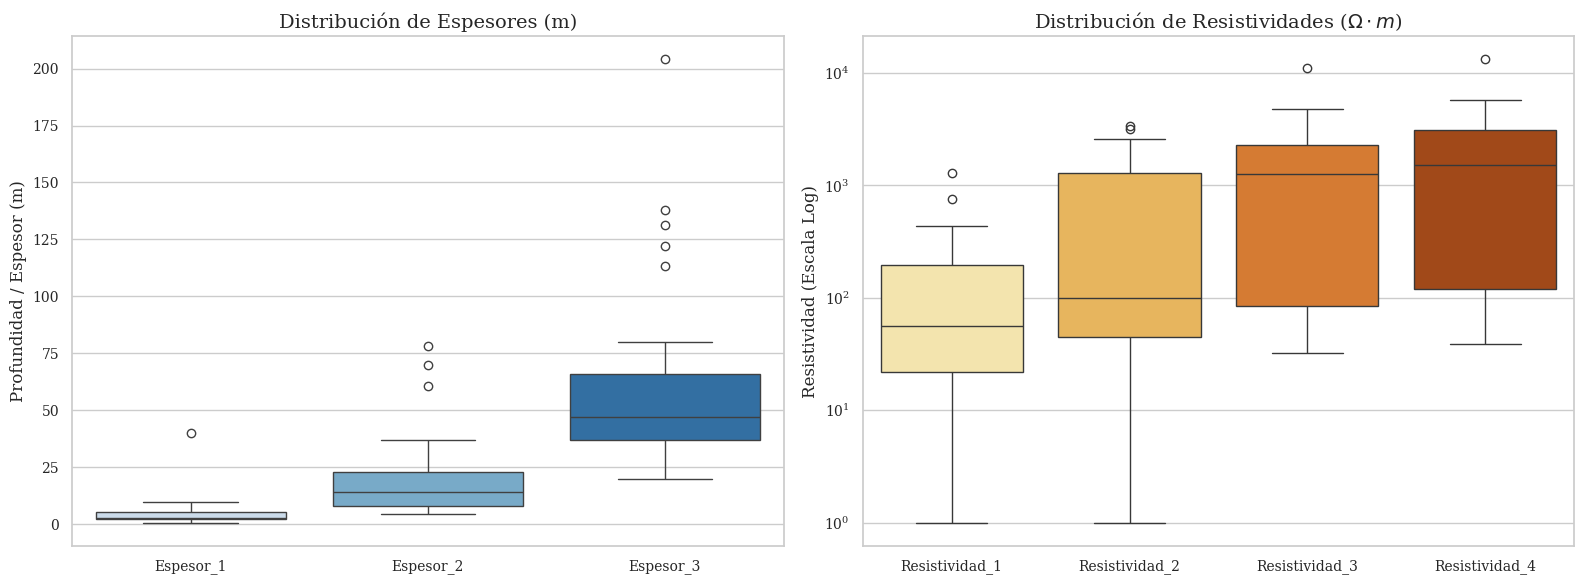


--- Matriz de Correlación (Pearson) ---


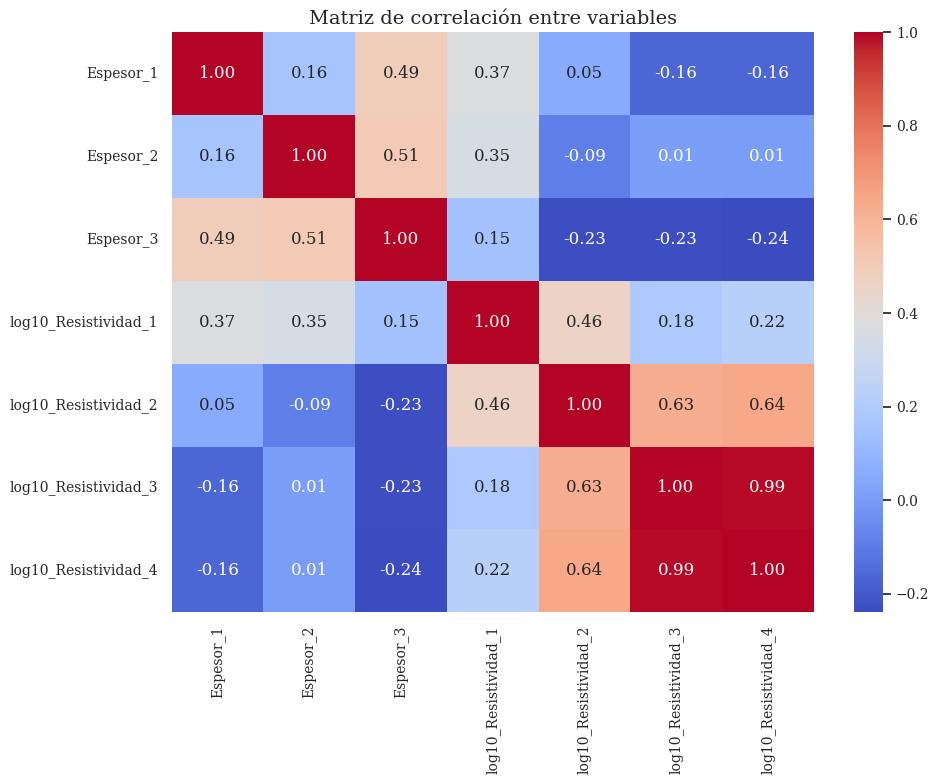


--- Análisis de Componentes Principales (PCA) ---
Varianza explicada por componentes: [0.39409889 0.28881838 0.13722736 0.09735993 0.04575825 0.03609853
 0.00063866]


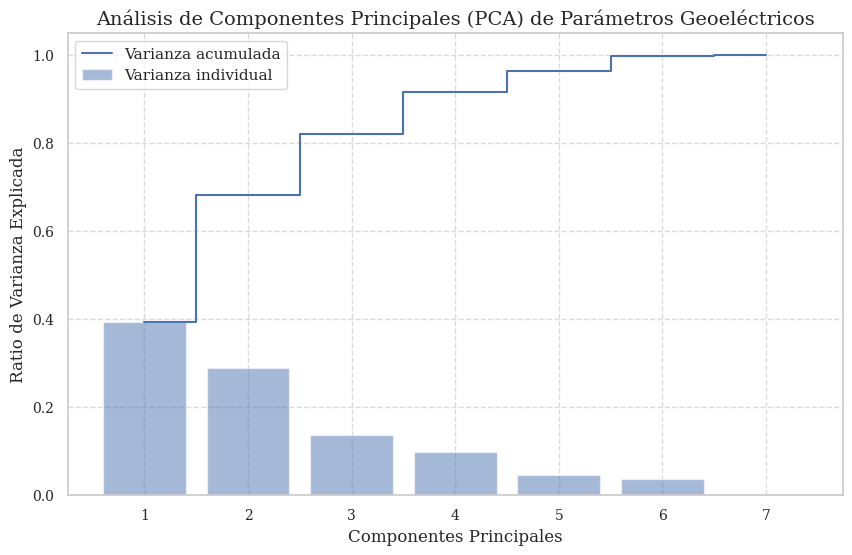


--- Verificación de Distribución para Priors Bayesianos ---


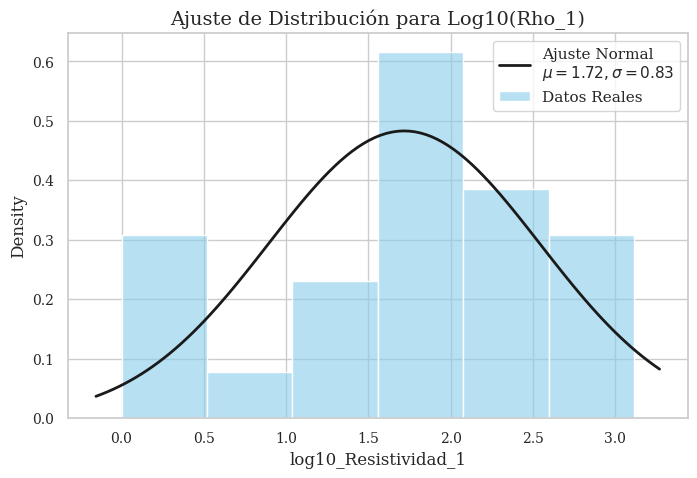

In [30]:
# ============================================
# 4. Ejecución del Análisis (Pipeline)
# ============================================

if __name__ == "__main__":
    # A. Carga de datos
    # Asegúrate de que la ruta sea correcta
    df = load_data("DATOS/Modelos-caracterizados-completo.csv")
    
    # Definición de columnas por tipo físico
    cols_espesor = ["Espesor_1", "Espesor_2", "Espesor_3"]
    cols_resistividad = ["Resistividad_1", "Resistividad_2", "Resistividad_3", "Resistividad_4"]
    
    print(f"Datos cargados: {df.shape[0]} sondeos, {df.shape[1]} variables.")

    # B. Preprocesamiento (Log Transform)
    # Generamos las columnas log10_Resistividad_X
    df_processed = preprocess_resistivity(df, cols_resistividad)
    
    # Lista de nuevas columnas log
    cols_log_res = [f'log10_{c}' for c in cols_resistividad]

    # C. Análisis Estadístico Descriptivo (Sobre Logs para resistividad)
    # Es más representativo reportar la media geométrica (media de los logs) para resistividad
    print("\n--- Estadísticos Descriptivos (Espesores y Log-Resistividades) ---")
    print(df_processed[cols_espesor + cols_log_res].describe().T)

    # D. Visualización de Control de Calidad (QC)
    print("\n--- Generando Boxplots de Control de Calidad ---")
    plot_geophysical_boxplots(df, cols_espesor, cols_resistividad)

    # E. Correlaciones en el espacio correcto (Lineal para espesor, Log para rho)
    print("\n--- Matriz de Correlación (Pearson) ---")
    # Usamos las variables transformadas para la correlación
    plot_correlation_heatmap(df_processed, cols_espesor + cols_log_res)

    # F. Análisis de Componentes Principales (PCA)
    print("\n--- Análisis de Componentes Principales (PCA) ---")
    # El PCA nos dirá si las 7 variables se pueden reducir (ej. principio de equivalencia S o T)
    pca_model, pca_data = perform_pca_analysis(df_processed, cols_espesor + cols_log_res)
    
    # G. Verificación de Distribución para Priors
    # Ejemplo: Ver si el log de la resistividad 1 se comporta como una Normal (Gaussiana)
    # Si log(rho) es normal -> rho es log-normal.
    print("\n--- Verificación de Distribución para Priors Bayesianos ---")
    plot_distribution_fit(df_processed['log10_Resistividad_1'].dropna(), 'Log10(Rho_1)', dist_name='norm')

###  --:

In [2]:

def plot_geophysical_distributions(df, res_cols, thick_cols):
    """
    Visualiza distribuciones de resistividad (escala log) y espesores
    para detección de outliers y coherencia geológica.
    """
    # 1. Transformación Logarítmica para Resistividades
    # Esto es crucial para visualizar órdenes de magnitud
    df_log = df.copy()
    log_res_cols = []
    for col in res_cols:
        new_col = f'log10_{col}'
        df_log[new_col] = np.log10(df[col])
        log_res_cols.append(new_col)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot de Resistividades (Escala Log)
    sns.boxplot(data=df_log[log_res_cols], ax=axes[0], palette="viridis")
    axes[0].set_title('Distribución de Resistividades ($log_{10} \Omega\cdot m$)', fontsize=14)
    axes[0].set_ylabel('$Log_{10}(\\rho)$')
    axes[0].grid(True, which="both", ls="--", alpha=0.5)
    
    # Plot de Espesores (Escala Lineal)
    sns.boxplot(data=df[thick_cols], ax=axes[1], palette="magma")
    axes[1].set_title('Distribución de Espesores de Capas', fontsize=14)
    axes[1].set_ylabel('Espesor (m)')
    axes[1].grid(True, ls="--", alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Uso sugerido (basado en las columnas que vi en tu notebook):
# columnas_res = ['Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']
# columnas_thk = ['Espesor_1', 'Espesor_2', 'Espesor_3']
# plot_geophysical_distributions(df, columnas_res, columnas_thk)

In [3]:
# ============================================
# Definiciones de funciones
# ============================================

def load_data(filepath: str) -> pd.DataFrame:
    """
    Carga el archivo CSV con los modelos caracterizados.

    Args:
        filepath (str): Ruta al archivo CSV.

    Returns:
        pd.DataFrame: DataFrame con los datos cargados.
    """
    return pd.read_csv(filepath)

In [4]:
def compute_statistics(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Calcula estadísticas descriptivas por sitio.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (List[str]): Columnas a analizar.

    Returns:
        pd.DataFrame: DataFrame con estadísticas agregadas.
    """
    grouped = df.groupby('Sitio')
    stats_df = grouped[cols].agg(['mean', 'std', 'median', 'min', 'max'])
    return stats_df


In [5]:
def compute_std_sum(stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula la suma de desviaciones estándar de espesores por sitio.

    Args:
        stats_df (pd.DataFrame): DataFrame de estadísticas.

    Returns:
        pd.DataFrame: DataFrame con suma de desviaciones estándar por sitio.
    """
    suma_std = (
        stats_df.loc[:, [('Espesor_1', 'std'), ('Espesor_2', 'std'), ('Espesor_3', 'std')]]
        .sum(axis=1)
        .to_dict()
    )
    df_suma = pd.DataFrame.from_dict(suma_std, orient='index', columns=['suma_std'])
    df_suma.reset_index(inplace=True)
    df_suma.rename(columns={'index': 'Sitio'}, inplace=True)
    return df_suma


In [6]:
def compute_site_correlations(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Calcula la correlación de Pearson entre todos los sitios
    en función de las variables seleccionadas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (List[str]): Columnas a considerar.

    Returns:
        pd.DataFrame: Matriz de correlación entre sitios.
    """
    # Calcular promedio por sitio
    site_means = df.groupby("Sitio")[cols].mean()
    corr_matrix = site_means.T.corr(method="pearson")
    return corr_matrix


In [7]:
def plot_correlation_matrix(corr_matrix: pd.DataFrame) -> None:
    """
    Grafica la matriz de correlación entre sitios.

    Args:
        corr_matrix (pd.DataFrame): Matriz de correlación.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de Correlación entre Sitios")
    plt.tight_layout()
    plt.show()

In [13]:
def plot_histograms(df: pd.DataFrame, cols: list) -> None:
    """
    Genera dos conjuntos de histogramas:
      - primer grupo: las 3 primeras columnas (espesores)
      - segundo grupo: las 4 últimas columnas (resistividades)

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Lista de columnas numéricas a graficar (se asume longitud 7).
    """
    # dividir en dos grupos: primeras 3 y últimas 4
    first_group = cols[:3]
    second_group = cols[3:]

    if first_group:
        df[first_group].hist(figsize=(12, 6), bins=20, edgecolor="black")
        #plt.suptitle("Distribuciones univariadas — Espesores", fontsize=14)
        plt.tight_layout()
        plt.show()

    if second_group:
        df[second_group].hist(figsize=(12, 6), bins=20, edgecolor="black")
        #plt.suptitle("Distribuciones univariadas — Resistividades", fontsize=14)
        plt.tight_layout()
        plt.show()


def plot_boxplots_by_site(df: pd.DataFrame, cols: list) -> None:
    """
    Genera boxplots por sitio para cada variable, separados en dos grupos:
    - Espesores (primeras 3 columnas)
    - Resistividades (últimas 4 columnas)

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas a graficar.
    """
    # Primer grupo: Espesores
    first_group = cols[:3]
    n1 = len(first_group)
    fig1, axes1 = plt.subplots(n1, 1, figsize=(12, 4*n1))
    if n1 == 1:
        axes1 = [axes1]
    for i, col in enumerate(first_group):
        sns.boxplot(x="Sitio", y=col, data=df, ax=axes1[i])
        axes1[i].set_title(f"Distribución de {col} por Sitio")
    plt.tight_layout()
    #plt.suptitle("Boxplots por Sitio — Espesores", y=1.02)
    plt.show()

    # Segundo grupo: Resistividades
    second_group = cols[3:]
    n2 = len(second_group)
    fig2, axes2 = plt.subplots(n2, 1, figsize=(12, 4*n2))
    if n2 == 1:
        axes2 = [axes2]
    for i, col in enumerate(second_group):
        sns.boxplot(x="Sitio", y=col, data=df, ax=axes2[i])
        axes2[i].set_title(f"Distribución de {col} por Sitio")
    plt.tight_layout()
    #plt.suptitle("Boxplots por Sitio — Resistividades", y=1.02)
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame, cols: list) -> None:
    """
    Grafica un heatmap de correlación entre columnas numéricas.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas numéricas a correlacionar.
    """
    corr = df[cols].corr(method="pearson")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación entre variables")
    plt.tight_layout()
    plt.show()


def plot_pairwise(df: pd.DataFrame, cols: list) -> None:
    """
    Genera un pairplot de dispersión cruzada entre variables.

    Args:
        df (pd.DataFrame): DataFrame original.
        cols (list): Columnas numéricas a considerar.
    """
    sns.pairplot(df[cols], diag_kind="kde")
    plt.suptitle("Relaciones bivariadas entre espesores y resistividades", y=1.02)
    plt.show()




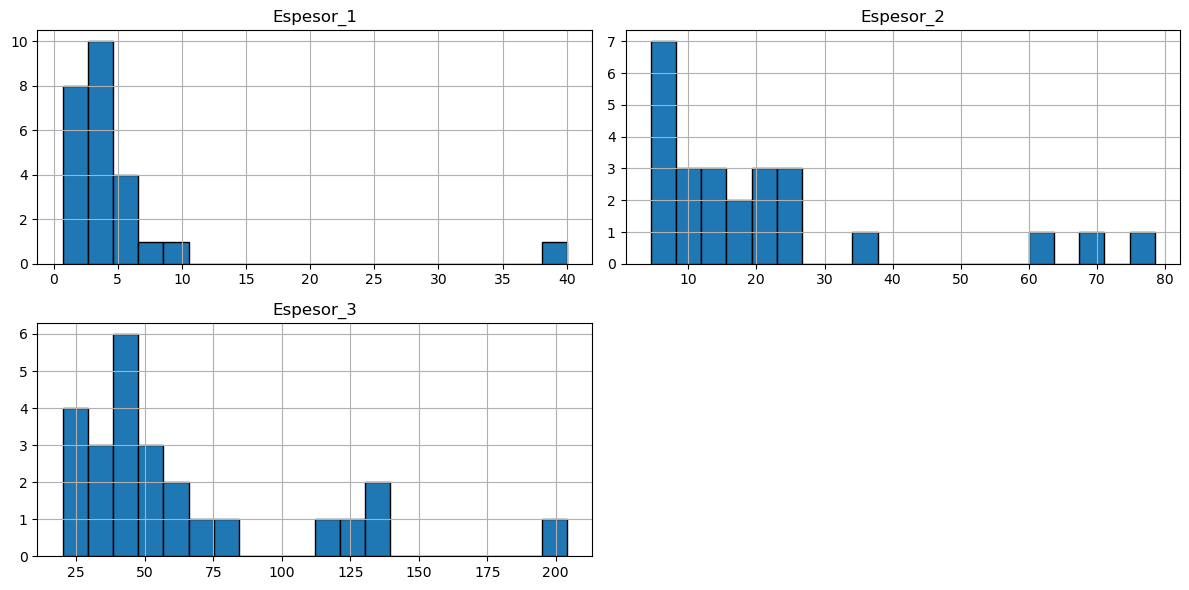

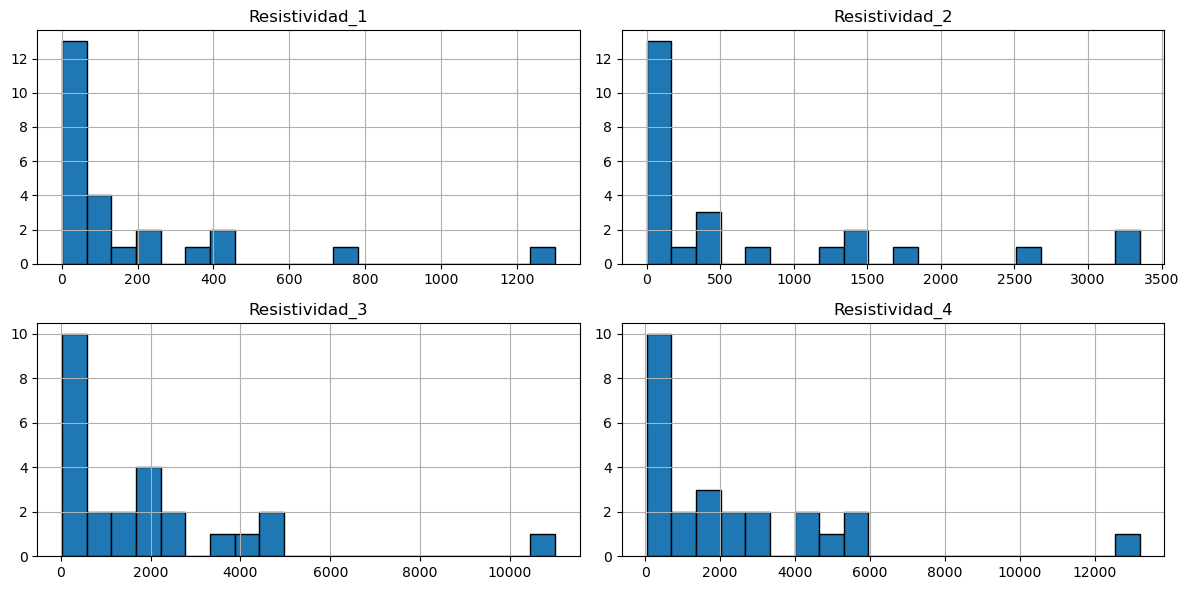

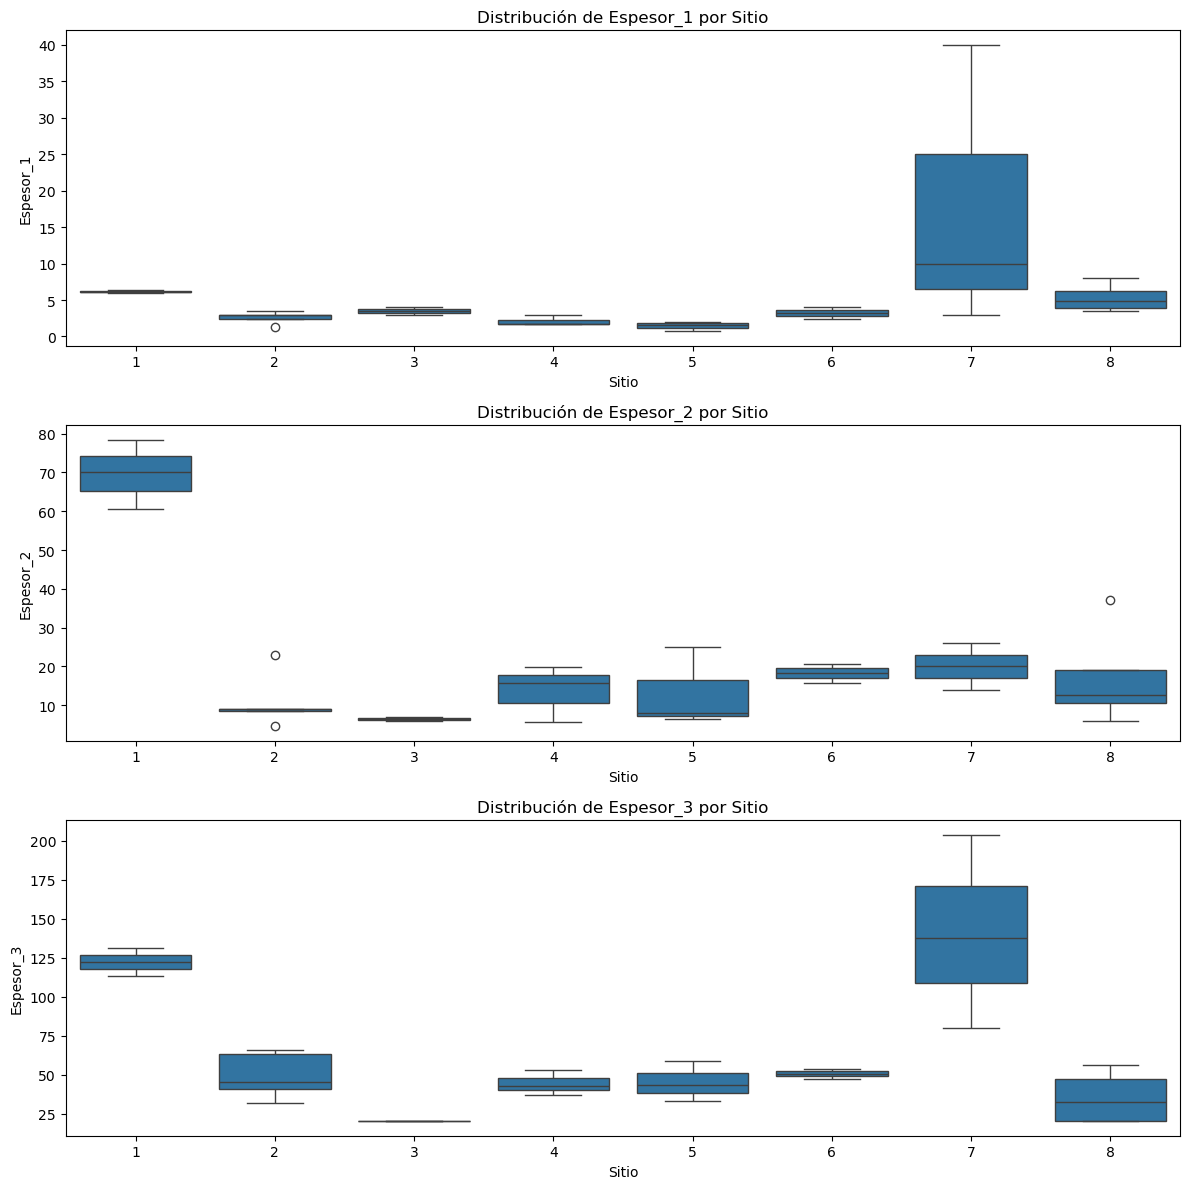

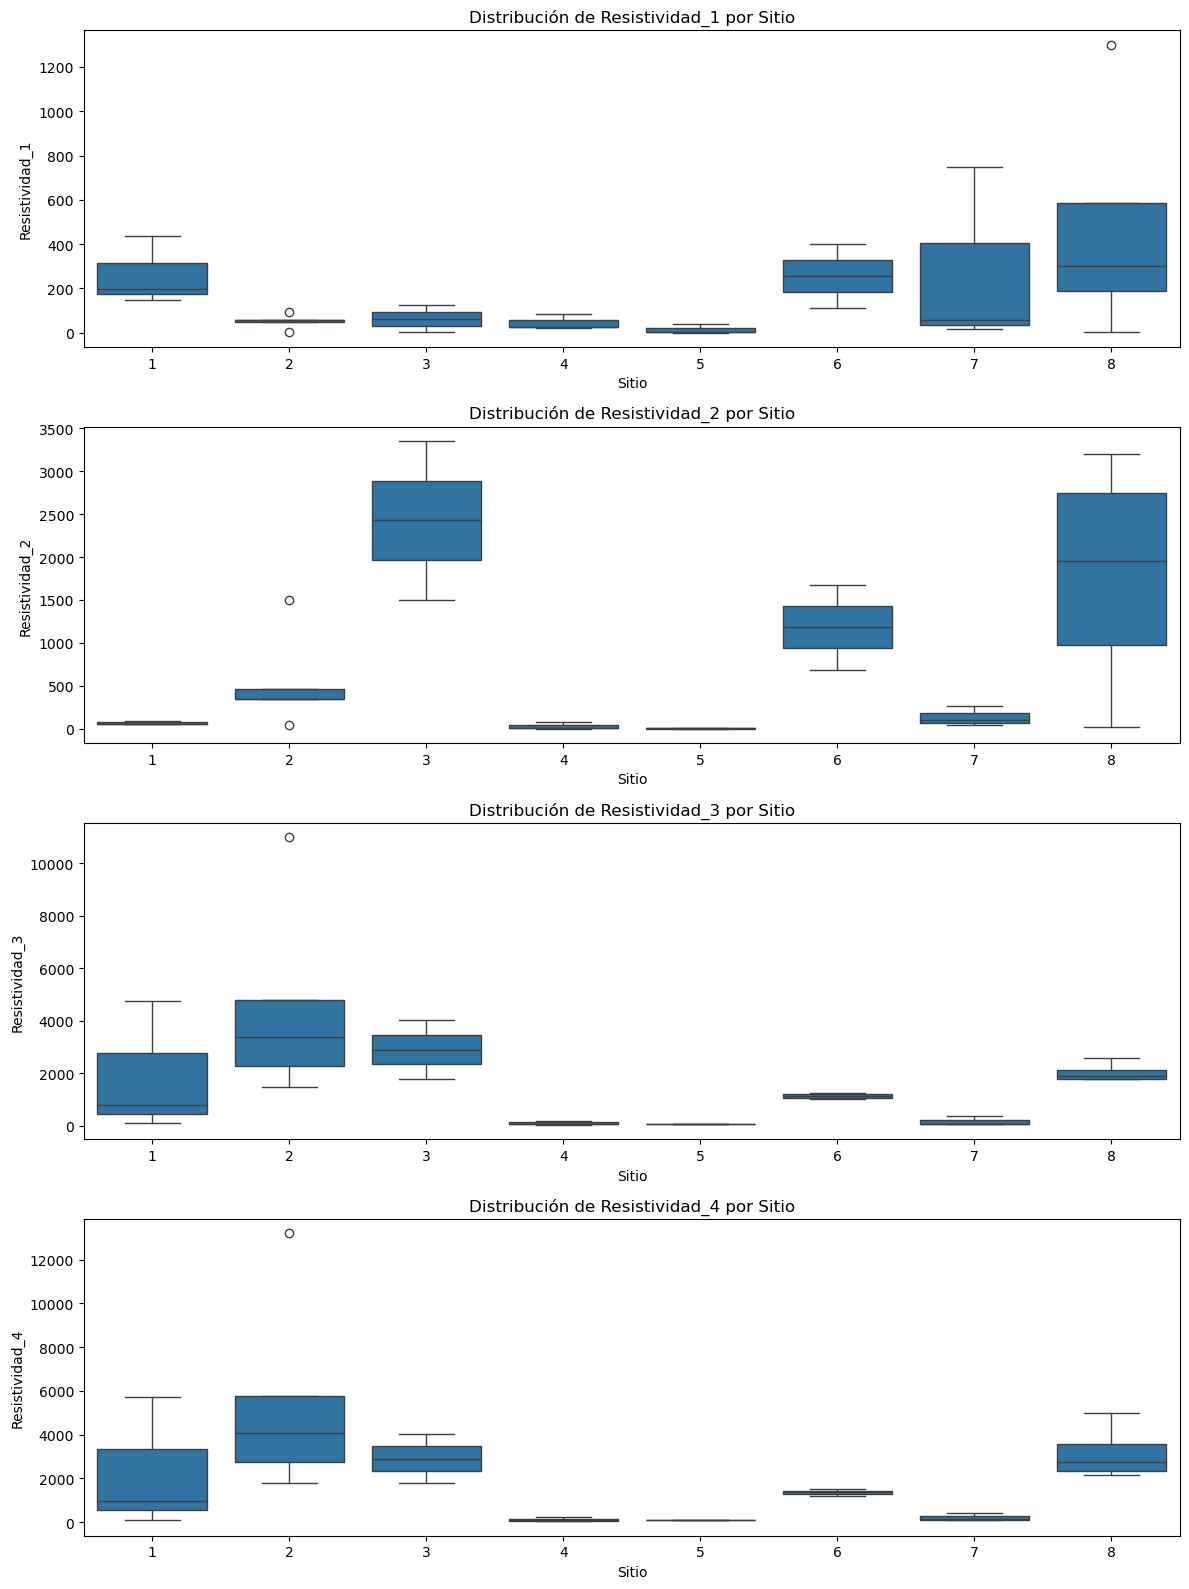

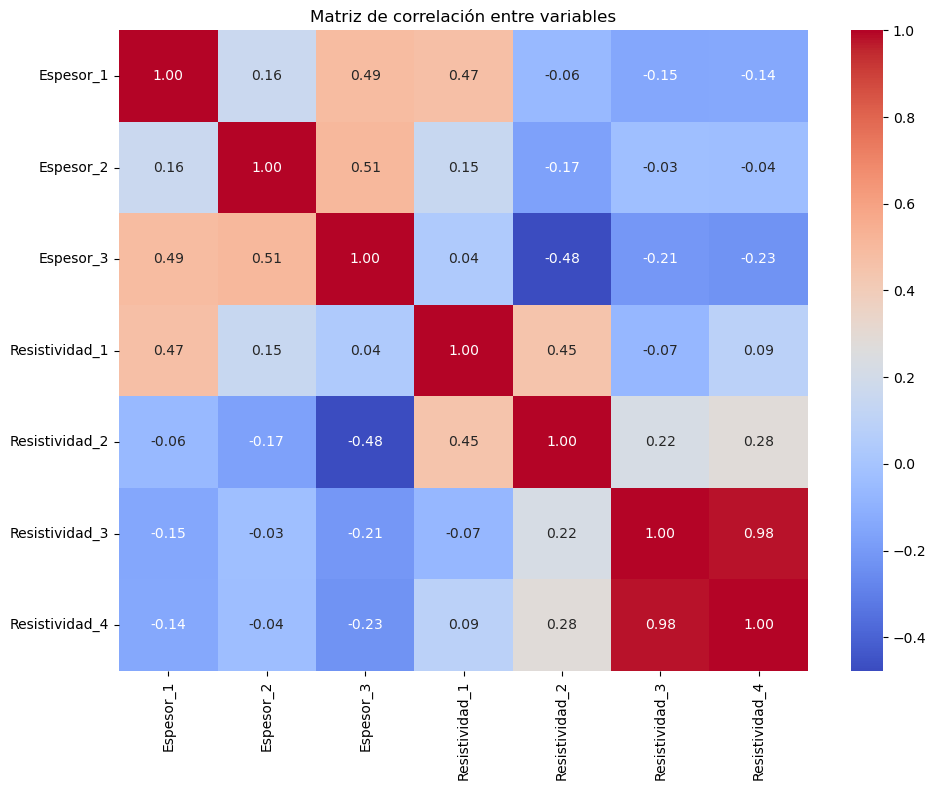

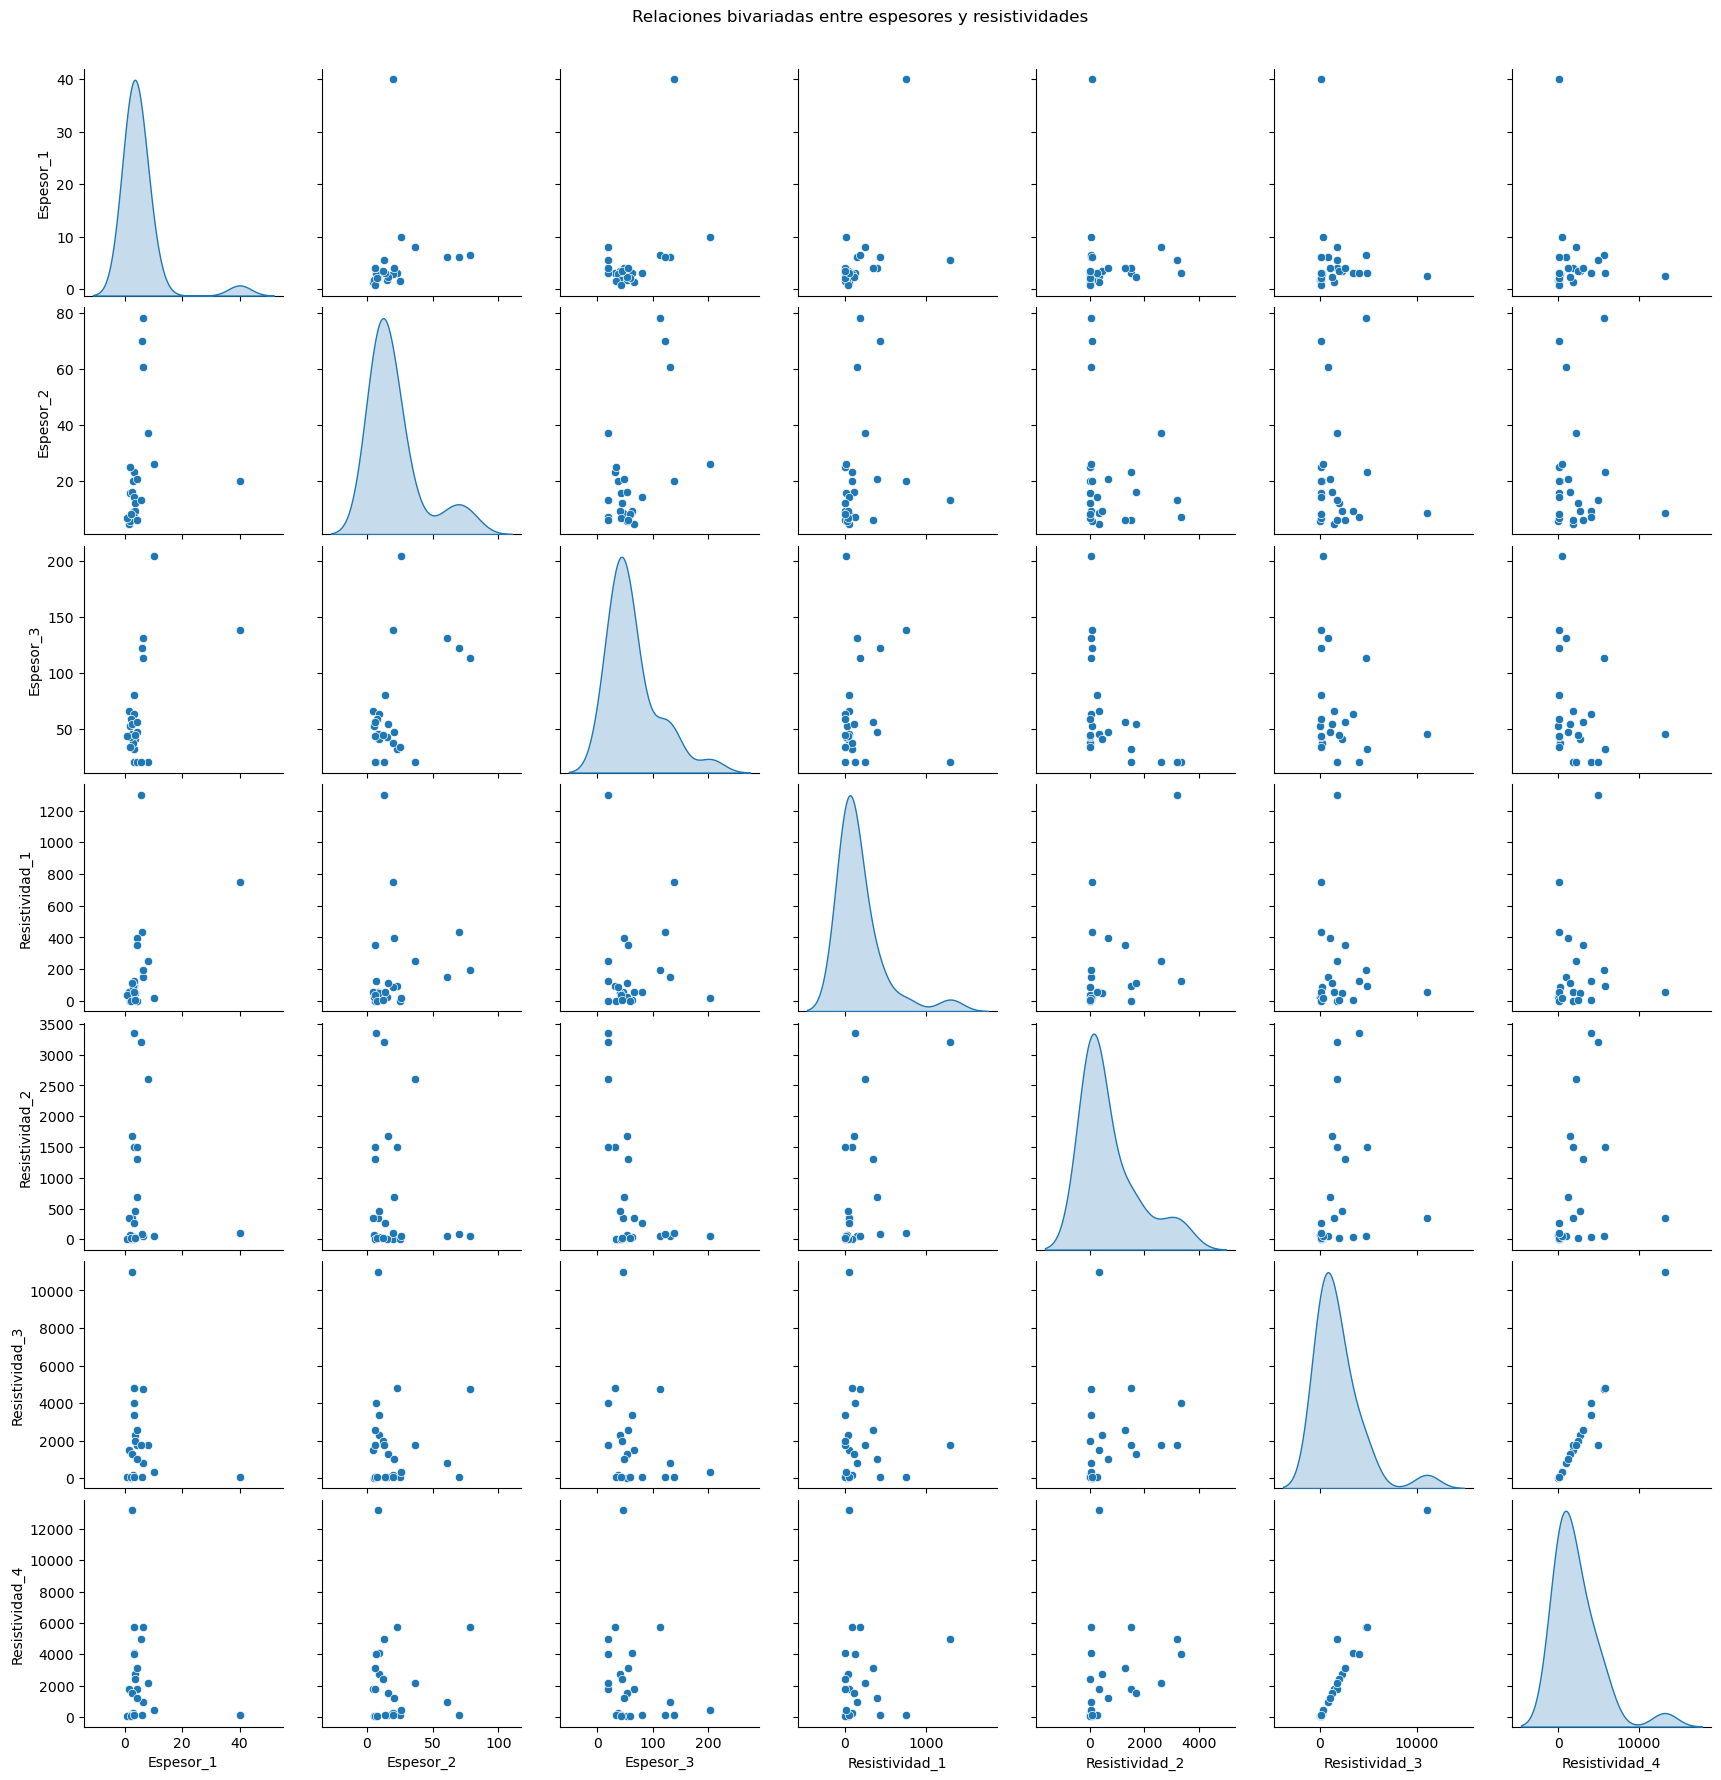

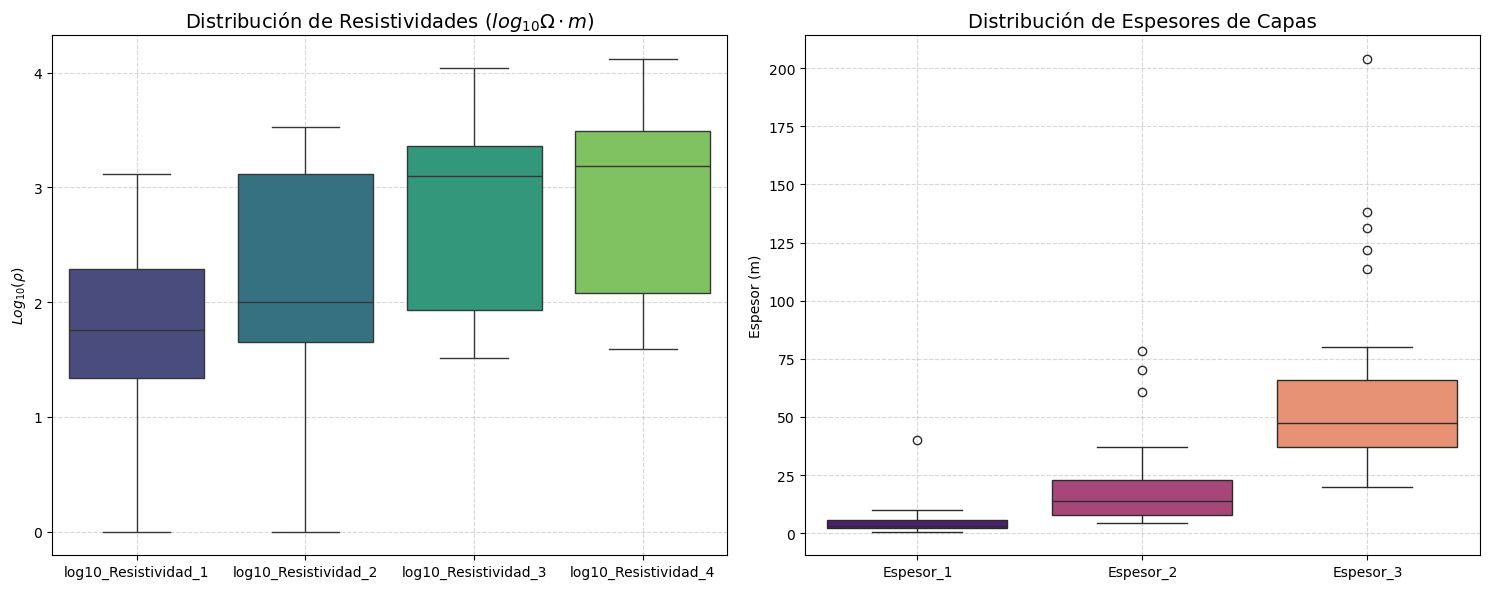

In [ ]:
if __name__ == "__main__":
    # 1. Cargar datos
    df = load_data("DATOS/Modelos-caracterizados-completo.csv")

    columnas = [
        "Espesor_1", "Espesor_2", "Espesor_3",
        "Resistividad_1", "Resistividad_2", 
        "Resistividad_3", "Resistividad_4"
    ]

    # Estadísticos básicos
    stats_df = compute_statistics(df, columnas)
    stats_df.to_csv("stats.csv")
    columnas_res = ['Resistividad_1', 'Resistividad_2', 'Resistividad_3', 'Resistividad_4']
    columnas_thk = ['Espesor_1', 'Espesor_2', 'Espesor_3']
    
    # 2. Histogramas
    plot_histograms(df, columnas)

    # 3. Boxplots por sitio
    plot_boxplots_by_site(df, columnas)

    # 4. Correlación (heatmap)
    plot_correlation_heatmap(df, columnas)

    # 5. Dispersión cruzada
    plot_pairwise(df, columnas)

    plot_geophysical_distributions(df, columnas_res, columnas_thk)

Archivo 'stats.csv' generado.
Archivo 'suma_std_por_sitio.csv' generado.
Archivo 'correlacion_sitios.csv' generado.


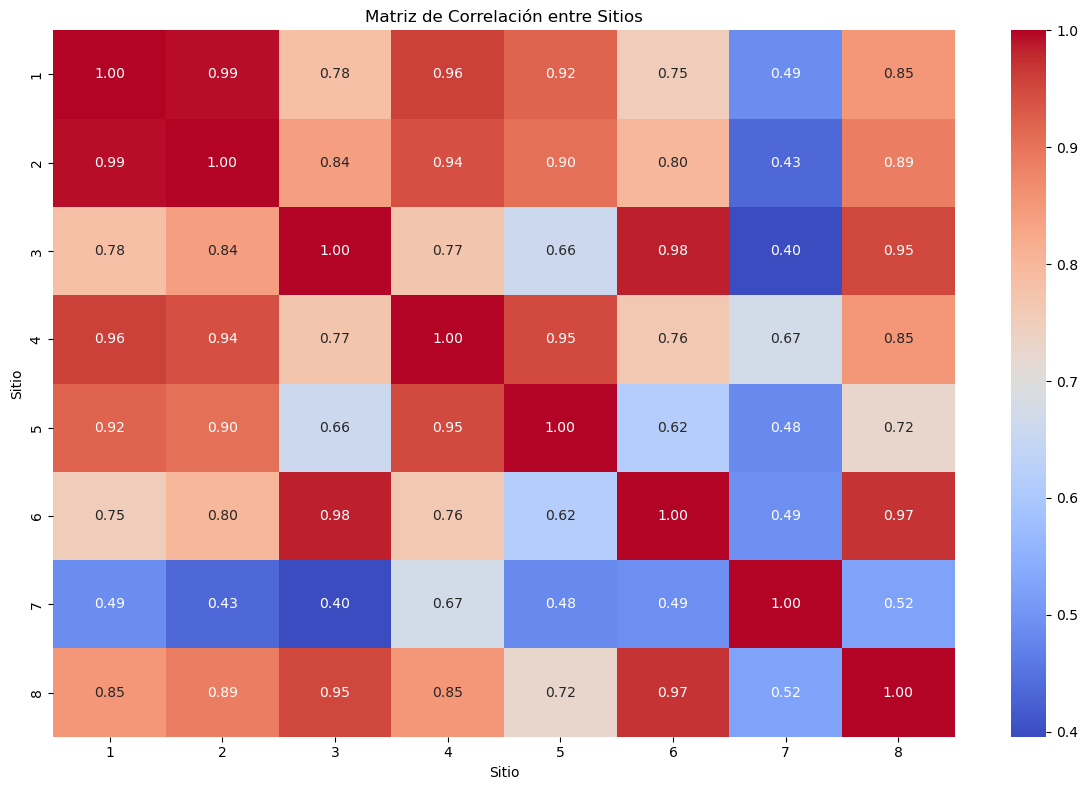

In [16]:
# ============================================
# Ejecución principal
# ============================================

if __name__ == "__main__":
    # 1. Cargar datos
    df = load_data("DATOS/Modelos-caracterizados-completo.csv")

    # 2. Definir columnas de interés
    columnas = [
        'Espesor_1', 'Espesor_2', 'Espesor_3',
        'Resistividad_1', 'Resistividad_2',
        'Resistividad_3', 'Resistividad_4'
    ]

    # 3. Estadísticos descriptivos por sitio
    stats_df = compute_statistics(df, columnas)
    stats_df.to_csv("DATOS/stats.csv")
    print("Archivo 'stats.csv' generado.")

    # 4. Suma de desviaciones estándar por sitio
    df_suma_std = compute_std_sum(stats_df)
    df_suma_std.to_csv("DATOS/suma_std_por_sitio.csv", index=False)
    print("Archivo 'suma_std_por_sitio.csv' generado.")

    # 5. Correlación general entre todos los sitios
    corr_matrix = compute_site_correlations(df, columnas)
    corr_matrix.to_csv("DATOS/correlacion_sitios.csv")
    print("Archivo 'correlacion_sitios.csv' generado.")

    # 6. Visualización de la matriz de correlación
    plot_correlation_matrix(corr_matrix)


>>> Datos cargados correctamente: 25 registros.

--- 1. Control de Calidad (Rangos Físicos) ---


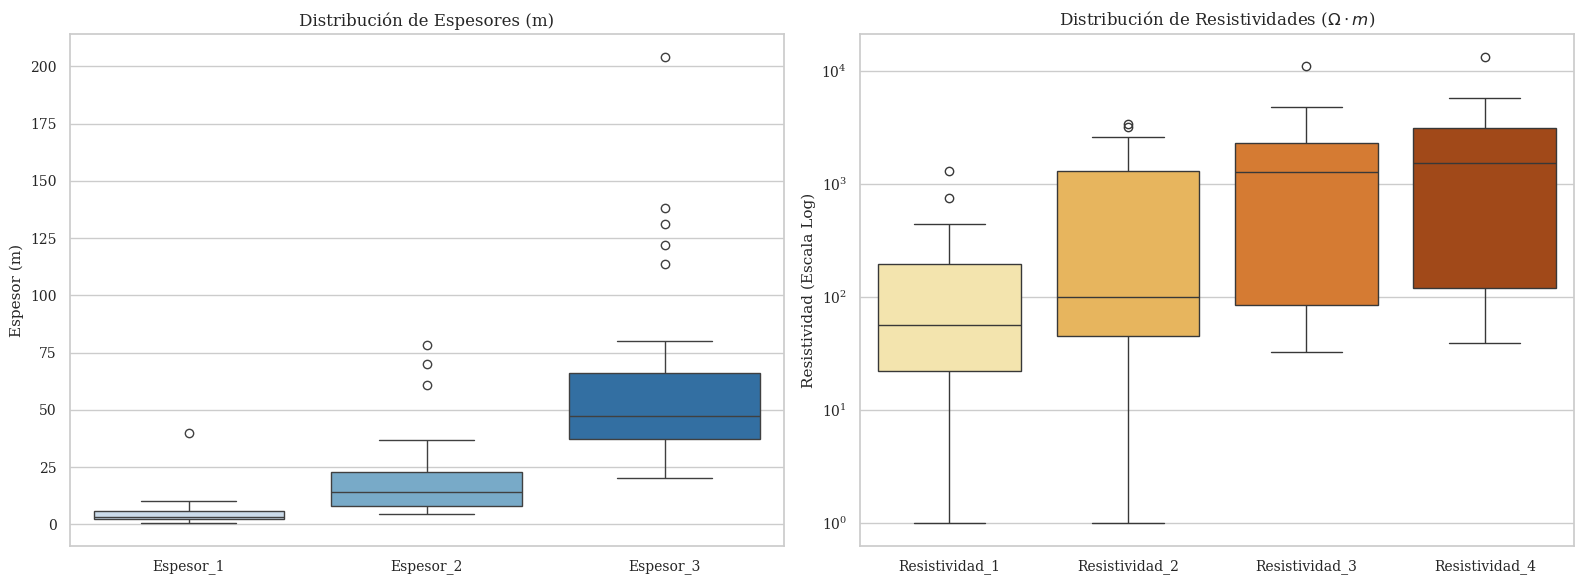


--- 2. Matriz de Correlación ---


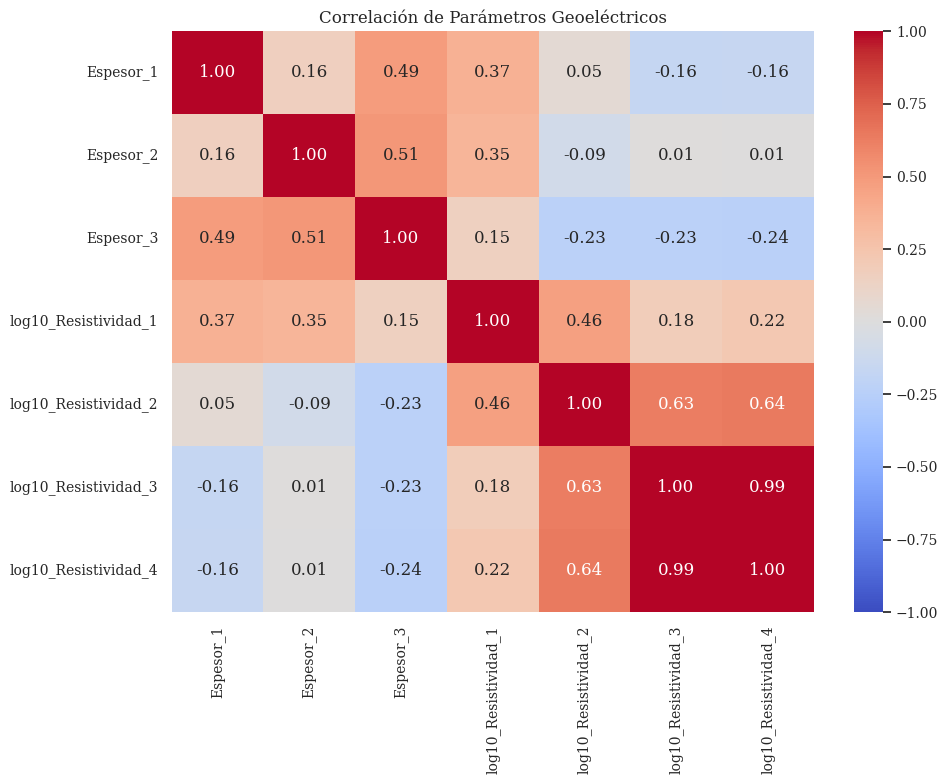


--- 3. Análisis de Componentes Principales (PCA) ---


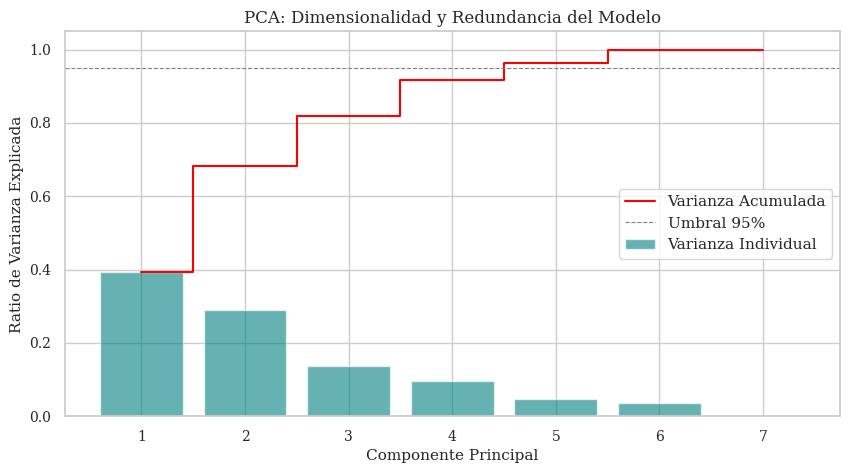

Varianza por componente: [0.3941 0.2888 0.1372 0.0974 0.0458 0.0361 0.0006]

--- 4. Validación de Distribuciones (Global) ---


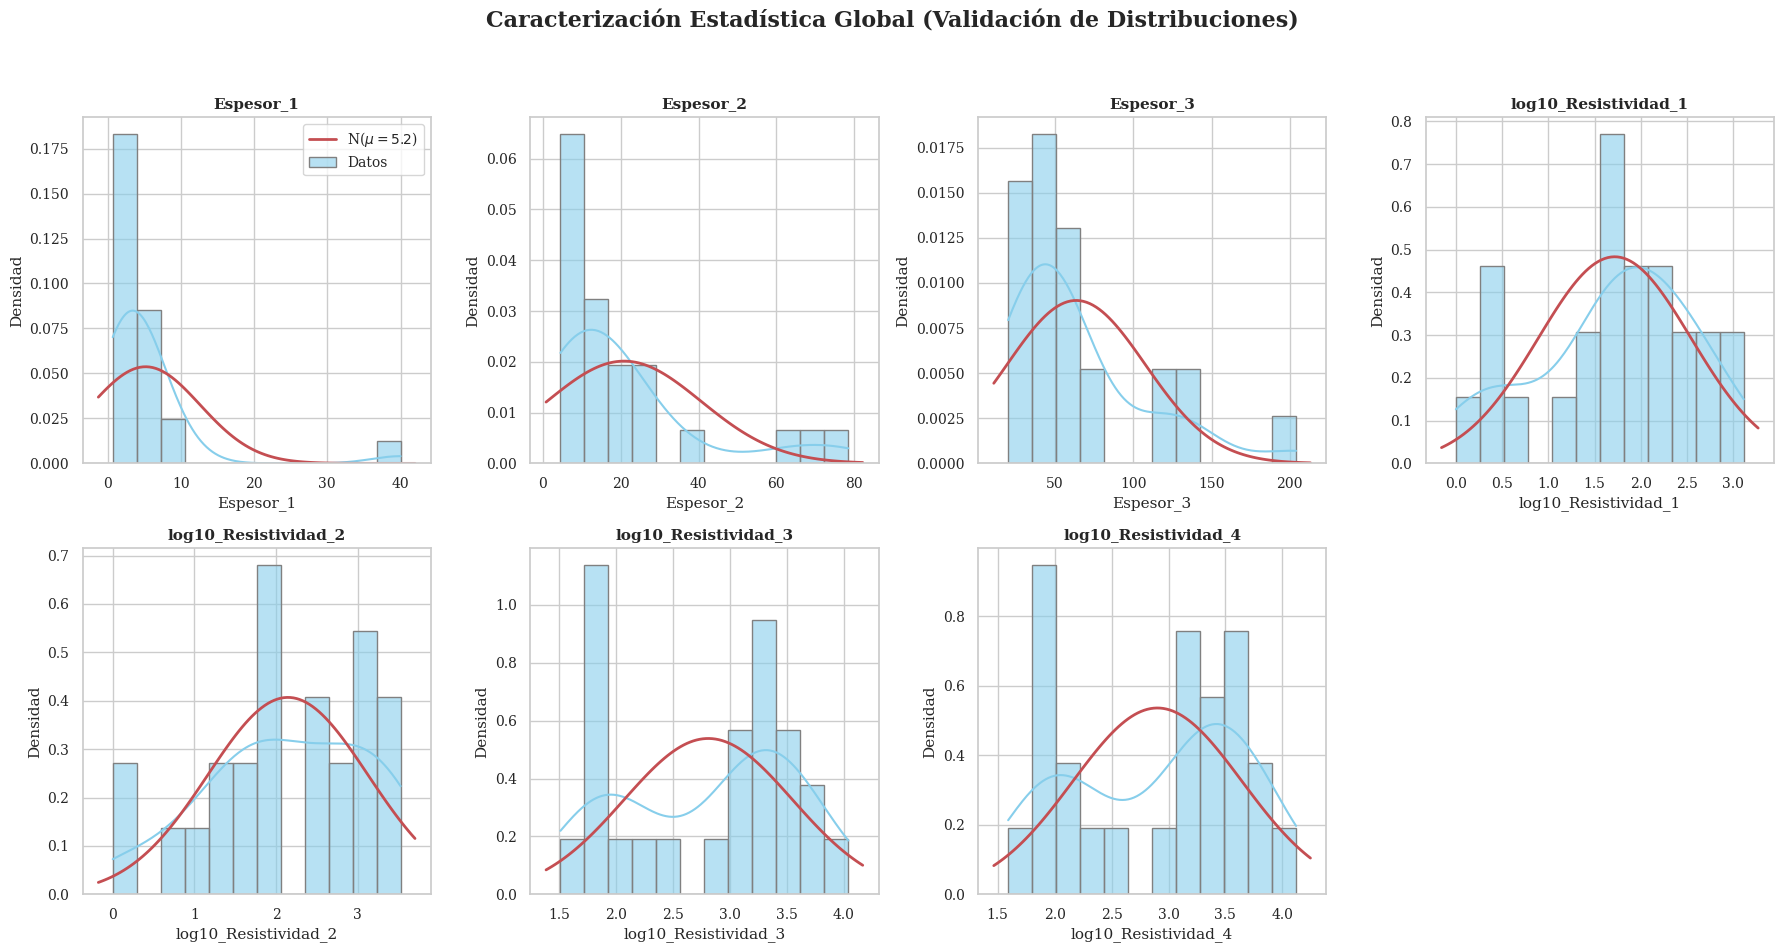

In [33]:
# ==============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS GEOFÍSICOS (EDA) - VERSIÓN FINAL INTEGRADA
# ==============================================================================

# 1. IMPORTACIONES Y CONFIGURACIÓN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Configuración de estilo (Estética Científica)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (12, 8)
})

# ==============================================================================
# 2. FUNCIONES DE PROCESAMIENTO
# ==============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    """Carga el dataset geofísico."""
    try:
        return pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error crítico: No se encontró el archivo en '{filepath}'")
        return pd.DataFrame()

def preprocess_resistivity(df: pd.DataFrame, res_cols: list) -> pd.DataFrame:
    """
    Transformación Logarítmica:
    Convierte resistividades a log10 para linealizar el problema geofísico
    y estabilizar la varianza estadística.
    """
    df_log = df.copy()
    for col in res_cols:
        # Se suma una constante infinitesimal para evitar log(0)
        df_log[f'log10_{col}'] = np.log10(df[col] + 1e-9)
    return df_log

# ==============================================================================
# 3. ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# ==============================================================================

def perform_pca_analysis(df: pd.DataFrame, features: list):
    """
    Evalúa la dimensionalidad real de los datos para detectar
    el Principio de Equivalencia (correlación entre parámetros).
    """
    # Limpieza y Estandarización
    x = df[features].dropna()
    if x.empty: return
    
    x_std = StandardScaler().fit_transform(x)

    # Cálculo de PCA
    pca = PCA()
    pca.fit(x_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Gráfico de Varianza (Scree Plot)
    plt.figure(figsize=(10, 5))
    bar_plot = plt.bar(range(1, len(explained_variance)+1), explained_variance, 
                       alpha=0.6, color='teal', label='Varianza Individual')
    step_plot = plt.step(range(1, len(cumulative_variance)+1), cumulative_variance, 
                         where='mid', color='red', label='Varianza Acumulada')
    
    plt.axhline(y=0.95, color='gray', linestyle='--', linewidth=0.8, label='Umbral 95%')
    plt.xlabel('Componente Principal')
    plt.ylabel('Ratio de Varianza Explicada')
    plt.title('PCA: Dimensionalidad y Redundancia del Modelo')
    plt.legend(loc='best')
    plt.show()
    
    print(f"Varianza por componente: {np.round(explained_variance, 4)}")
    return pca

# ==============================================================================
# 4. FUNCIONES DE VISUALIZACIÓN
# ==============================================================================

def plot_geophysical_boxplots(df: pd.DataFrame, thick_cols: list, res_cols: list):
    """
    Control de Calidad:
    - Espesores en escala lineal.
    - Resistividades en escala logarítmica (para ver todos los órdenes de magnitud).
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Panel Espesores
    sns.boxplot(data=df[thick_cols], ax=axes[0], palette="Blues")
    axes[0].set_title('Distribución de Espesores (m)')
    axes[0].set_ylabel('Espesor (m)')
    
    # Panel Resistividades (Log)
    sns.boxplot(data=df[res_cols], ax=axes[1], palette="YlOrBr")
    axes[1].set_yscale('log')
    axes[1].set_title(r'Distribución de Resistividades ($\Omega \cdot m$)')
    axes[1].set_ylabel('Resistividad (Escala Log)')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df: pd.DataFrame, cols: list):
    """Matriz de correlación de Pearson."""
    plt.figure(figsize=(10, 8))
    corr = df[cols].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlación de Parámetros Geoeléctricos")
    plt.tight_layout()
    plt.show()

def analyze_global_distributions(df: pd.DataFrame, thick_cols: list, log_res_cols: list):
    """
    Análisis Global (Todos los sitios):
    Usa un número bajo de 'bins' (12) para datasets pequeños.
    Superpone una curva Normal para validar la distribución estadística.
    """
    all_vars = thick_cols + log_res_cols
    
    # Configuración de la cuadrícula de gráficos (2 filas, 4 columnas)
    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    fig.suptitle('Caracterización Estadística Global (Validación de Distribuciones)', 
                 fontsize=16, weight='bold')
    
    axes = axes.flatten()
    
    for i, col in enumerate(all_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if not data.empty:
            # 1. Histograma (Bins=12 para que se vea sólido con pocos datos)
            sns.histplot(data, bins=12, kde=True, stat="density", ax=ax,
                         color="skyblue", edgecolor="gray", alpha=0.6, label='Datos')
            
            # 2. Ajuste Gaussiano (Normal)
            mu, std = stats.norm.fit(data)
            xmin, xmax = ax.get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = stats.norm.pdf(x, mu, std)
            
            # Curva teórica
            ax.plot(x, p, 'r-', linewidth=2, label=f'N($\mu={mu:.1f}$)')
            
            # Formato
            ax.set_title(f'{col}', fontsize=11, weight='bold')
            ax.set_ylabel('Densidad')
            if i == 0: ax.legend(fontsize='small') # Solo leyenda en el primero para no saturar
        
    # Ocultar ejes vacíos si sobran cuadros en la cuadrícula
    for j in range(len(all_vars), len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 5. EJECUCIÓN PRINCIPAL
# ==============================================================================

if __name__ == "__main__":
    # 1. Definición de variables físicas
    # Ajusta la ruta a tu archivo CSV
    FILE_PATH = "DATOS/Modelos-caracterizados-completo.csv"
    
    cols_espesor = ["Espesor_1", "Espesor_2", "Espesor_3"]
    cols_resistividad = ["Resistividad_1", "Resistividad_2", "Resistividad_3", "Resistividad_4"]
    
    # 2. Carga
    df = load_data(FILE_PATH)
    
    if not df.empty:
        print(f">>> Datos cargados correctamente: {df.shape[0]} registros.")
        
        # 3. Preprocesamiento (Transformación Log)
        df_processed = preprocess_resistivity(df, cols_resistividad)
        cols_log_res = [f'log10_{c}' for c in cols_resistividad] # Nombres nuevas columnas
        
        # 4. Control de Calidad (Boxplots Físicos)
        print("\n--- 1. Control de Calidad (Rangos Físicos) ---")
        plot_geophysical_boxplots(df, cols_espesor, cols_resistividad)
        
        # 5. Correlaciones
        print("\n--- 2. Matriz de Correlación ---")
        plot_correlation_heatmap(df_processed, cols_espesor + cols_log_res)
        
        # 6. PCA (Dimensionalidad)
        print("\n--- 3. Análisis de Componentes Principales (PCA) ---")
        perform_pca_analysis(df_processed, cols_espesor + cols_log_res)
        
        # 7. Distribuciones Globales (Ajuste para pocos datos)
        print("\n--- 4. Validación de Distribuciones (Global) ---")
        analyze_global_distributions(df_processed, cols_espesor, cols_log_res)
        
    else:
        print("No se pudo iniciar el análisis.")

>>> Transformando resistividades a escala logarítmica...

>>> Realizando PCA preliminar...
Varianza explicada por 3 primeras componentes: 82.01%

>>> Ejecutando prueba de bondad de ajuste (Goodness of Fit)...
    Compitiendo: Normal, LogNormal, Gamma, Exponencial, Weibull


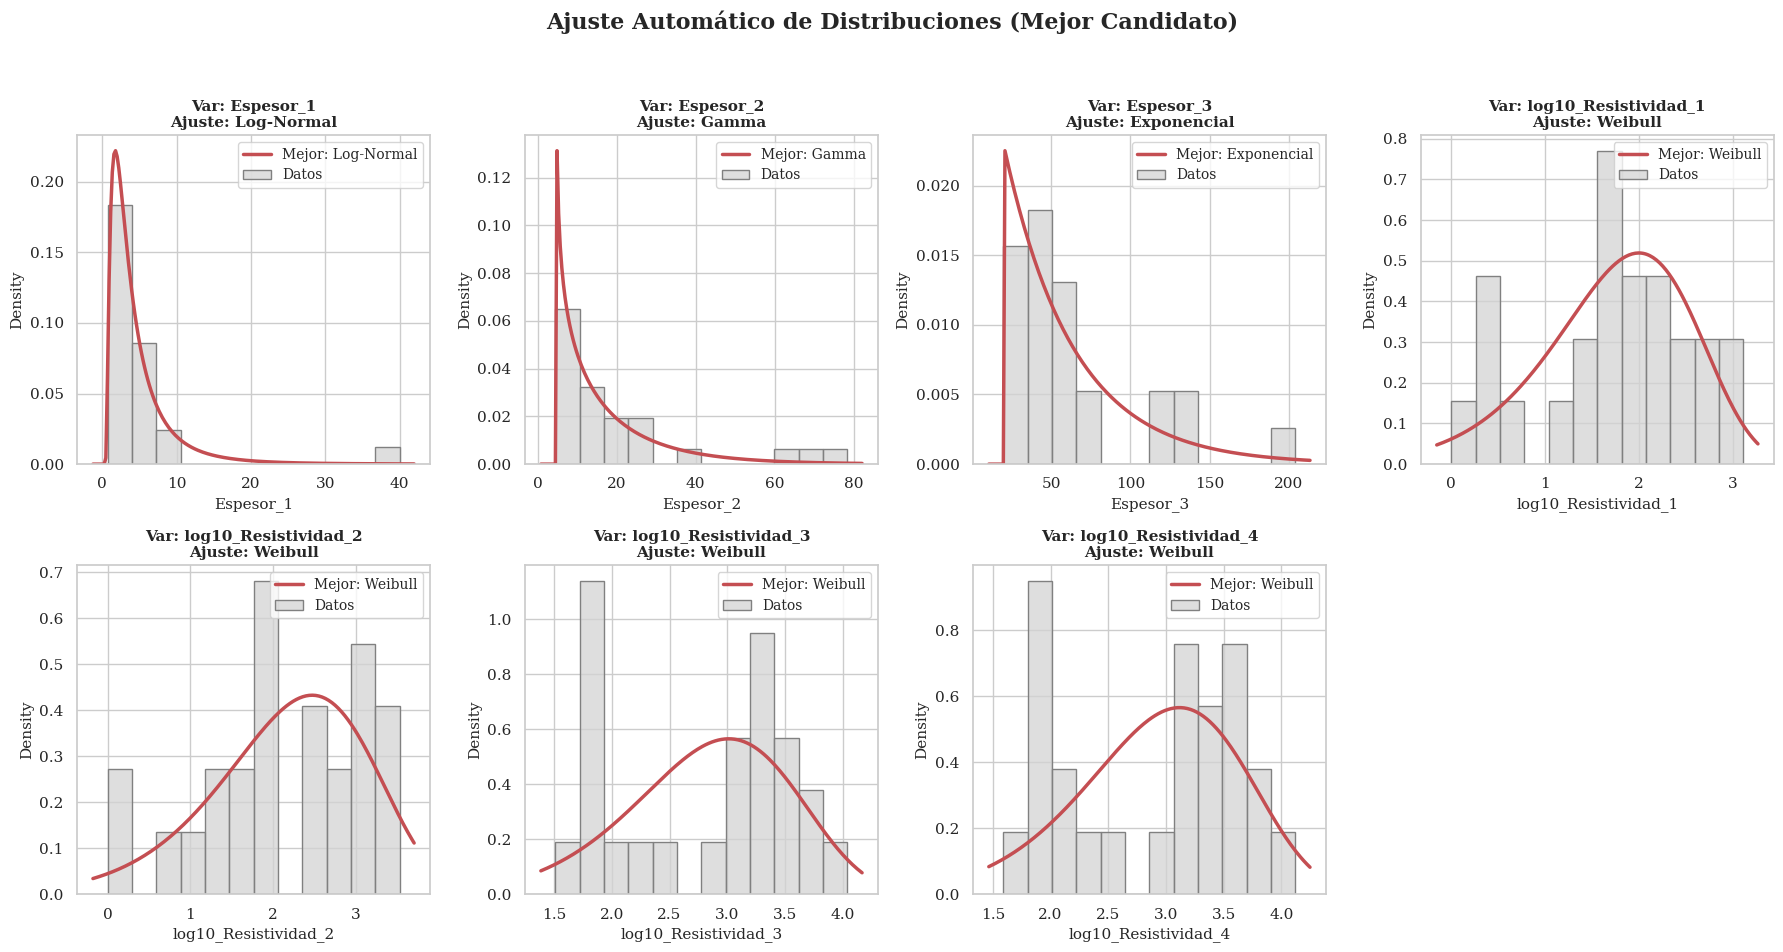

In [34]:
# ==============================================================================
# ANÁLISIS GEOFÍSICO: AJUSTE AUTOMÁTICO DE MULTIPLES DISTRIBUCIONES
# ==============================================================================

# 1. IMPORTACIONES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

# Ignorar advertencias de ajuste si alguna distribución falla al converger
warnings.filterwarnings('ignore')

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 11,
    'axes.titlesize': 10,
    'figure.figsize': (14, 10)
})

# ==============================================================================
# 2. PROCESAMIENTO DE DATOS
# ==============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    try:
        return pd.read_csv(filepath)
    except FileNotFoundError:
        return pd.DataFrame()

def preprocess_resistivity(df: pd.DataFrame, res_cols: list) -> pd.DataFrame:
    """Log-transformación de resistividades para linealizar."""
    df_log = df.copy()
    for col in res_cols:
        df_log[f'log10_{col}'] = np.log10(df[col] + 1e-9)
    return df_log

# ==============================================================================
# 3. MOTOR DE AJUSTE DE DISTRIBUCIONES (NUEVO)
# ==============================================================================

def get_best_distribution(data):
    """
    Prueba múltiples distribuciones y devuelve la que mejor se ajusta (menor error).
    """
    # Lista de distribuciones candidatas comunes en geociencias
    dist_names = ['norm', 'lognorm', 'gamma', 'expon', 'weibull_min']
    
    best_dist_name = None
    best_params = {}
    best_sse = np.inf
    
    # Crear histograma base para calcular error
    y, x = np.histogram(data, bins=12, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0  # Centros de los bins

    for name in dist_names:
        try:
            dist = getattr(stats, name)
            params = dist.fit(data)
            
            # Calcular PDF teórica
            pdf_vals = dist.pdf(x, *params)
            
            # Calcular Suma de Errores Cuadráticos (SSE)
            sse = np.sum(np.power(y - pdf_vals, 2.0))
            
            if sse < best_sse:
                best_sse = sse
                best_dist_name = name
                best_params = params
        except Exception:
            continue
            
    return best_dist_name, best_params

# ==============================================================================
# 4. VISUALIZACIÓN AVANZADA
# ==============================================================================

def plot_multi_distribution_analysis(df: pd.DataFrame, thick_cols: list, log_res_cols: list):
    """
    Grafica histogramas y superpone la MEJOR distribución encontrada.
    """
    all_vars = thick_cols + log_res_cols
    
    # Configuración de cuadrícula
    n_vars = len(all_vars)
    rows = (n_vars // 4) + (1 if n_vars % 4 > 0 else 0)
    fig, axes = plt.subplots(rows, 4, figsize=(18, 5 * rows))
    
    fig.suptitle('Ajuste Automático de Distribuciones (Mejor Candidato)', fontsize=16, weight='bold')
    axes = axes.flatten()
    
    for i, col in enumerate(all_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if not data.empty:
            # 1. Encontrar la mejor distribución
            best_name, params = get_best_distribution(data)
            
            # 2. Graficar Histograma (Bins bajos para pocos datos)
            sns.histplot(data, bins=12, stat="density", ax=ax, 
                         color="lightgray", edgecolor="gray", label='Datos')
            
            # 3. Graficar la curva ganadora
            xmin, xmax = ax.get_xlim()
            x_plot = np.linspace(xmin, xmax, 200)
            
            dist_func = getattr(stats, best_name)
            y_plot = dist_func.pdf(x_plot, *params)
            
            # Nombre amigable para el gráfico
            nombres_bonitos = {
                'norm': 'Normal', 'lognorm': 'Log-Normal', 
                'gamma': 'Gamma', 'expon': 'Exponencial', 
                'weibull_min': 'Weibull'
            }
            label_dist = nombres_bonitos.get(best_name, best_name)
            
            ax.plot(x_plot, y_plot, 'r-', linewidth=2.5, label=f'Mejor: {label_dist}')
            
            # Decoración
            ax.set_title(f'Var: {col}\nAjuste: {label_dist}', fontsize=11, weight='bold')
            ax.legend(loc='upper right', fontsize='small', frameon=True)
            
    # Limpiar ejes vacíos
    for j in range(len(all_vars), len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 5. EJECUCIÓN PRINCIPAL
# ==============================================================================

if __name__ == "__main__":
    # 1. Carga
    FILE_PATH = "DATOS/Modelos-caracterizados-completo.csv" # <--- VERIFICA TU RUTA
    df = load_data(FILE_PATH)
    
    if not df.empty:
        # Definición de variables
        cols_espesor = ["Espesor_1", "Espesor_2", "Espesor_3"]
        cols_resistividad = ["Resistividad_1", "Resistividad_2", "Resistividad_3", "Resistividad_4"]
        
        # 2. Preprocesamiento
        print(">>> Transformando resistividades a escala logarítmica...")
        df_processed = preprocess_resistivity(df, cols_resistividad)
        cols_log_res = [f'log10_{c}' for c in cols_resistividad]

        # 3. PCA (Opcional, para contexto)
        print("\n>>> Realizando PCA preliminar...")
        x_std = StandardScaler().fit_transform(df_processed[cols_espesor + cols_log_res].dropna())
        pca = PCA().fit(x_std)
        print(f"Varianza explicada por 3 primeras componentes: {np.sum(pca.explained_variance_ratio_[:3])*100:.2f}%")

        # 4. Análisis de Distribuciones Múltiples
        print("\n>>> Ejecutando prueba de bondad de ajuste (Goodness of Fit)...")
        print("    Compitiendo: Normal, LogNormal, Gamma, Exponencial, Weibull")
        
        plot_multi_distribution_analysis(df_processed, cols_espesor, cols_log_res)
        
    else:
        print("Error: No se cargaron datos.")


>>> Calculando ajustes con SSE y Valor-P (Kolmogorov-Smirnov)...


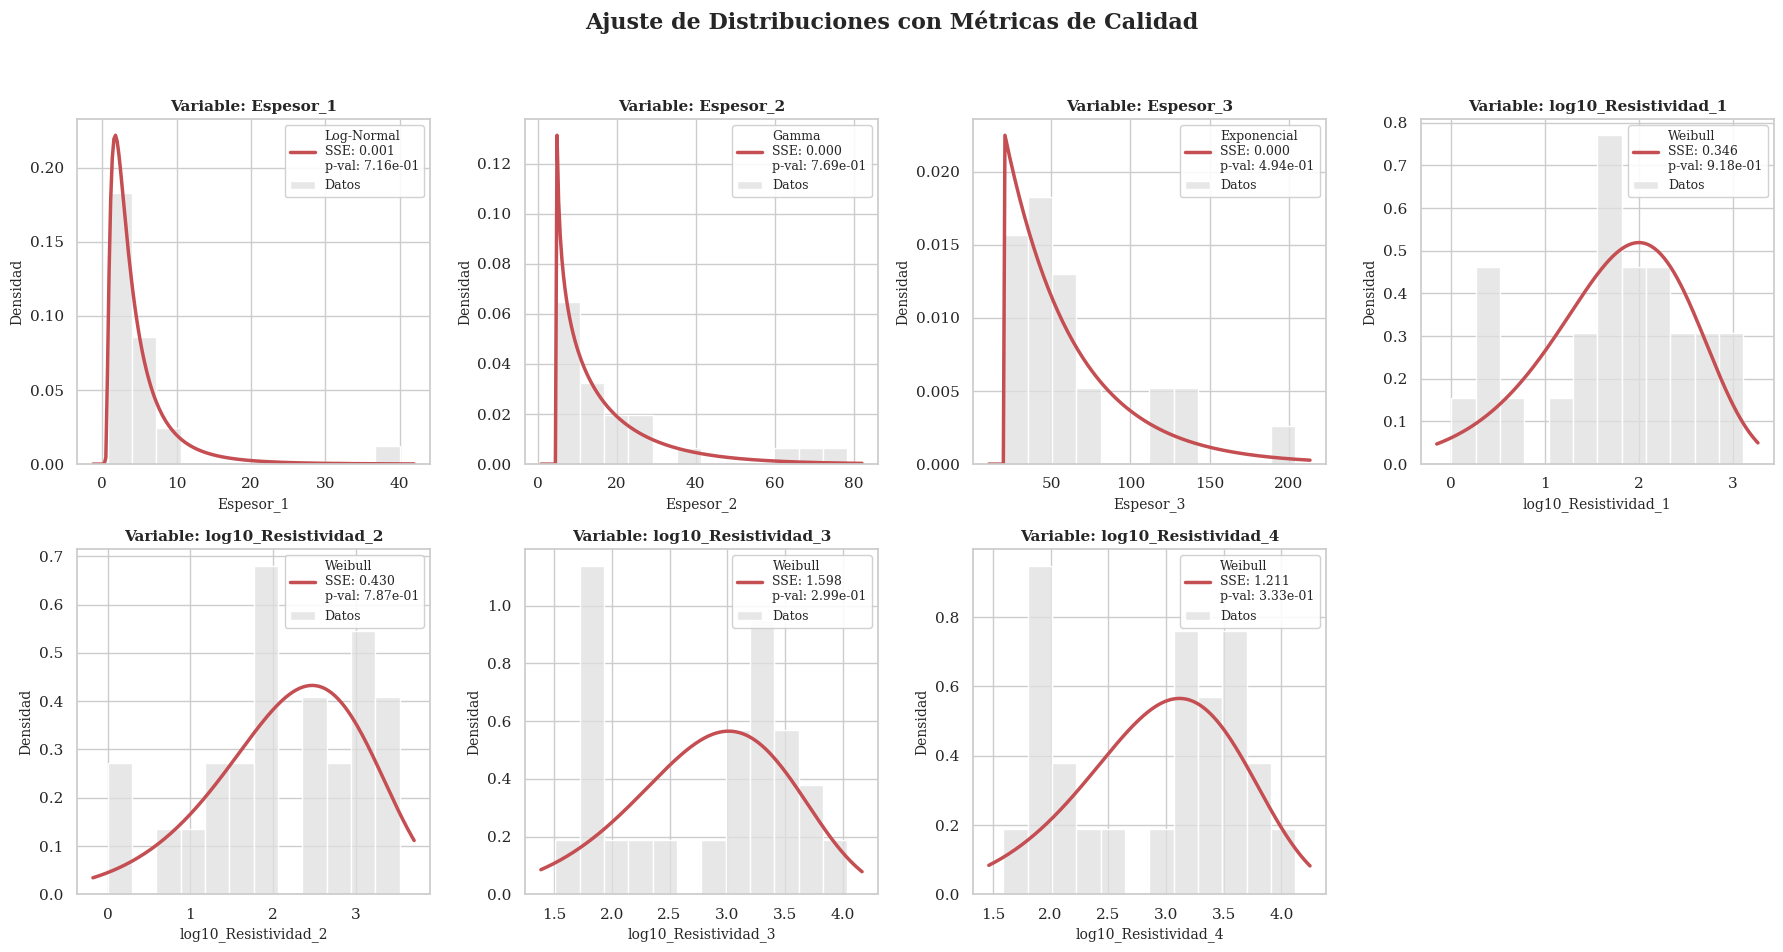

In [35]:
# ==============================================================================
# ANÁLISIS GEOFÍSICO: AJUSTE DE DISTRIBUCIONES CON METRICAS (SSE y P-VALUE)
# ==============================================================================

# 1. IMPORTACIONES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

# Ignorar advertencias de convergencia
warnings.filterwarnings('ignore')

# Estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'legend.fontsize': 9,
    'figure.figsize': (16, 12)
})

# ==============================================================================
# 2. PROCESAMIENTO
# ==============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    try:
        return pd.read_csv(filepath)
    except FileNotFoundError:
        return pd.DataFrame()

def preprocess_resistivity(df: pd.DataFrame, res_cols: list) -> pd.DataFrame:
    df_log = df.copy()
    for col in res_cols:
        df_log[f'log10_{col}'] = np.log10(df[col] + 1e-9)
    return df_log

# ==============================================================================
# 3. MOTOR DE AJUSTE ESTADÍSTICO (ACTUALIZADO)
# ==============================================================================

def get_best_distribution_with_stats(data):
    """
    Prueba distribuciones y devuelve la mejor basada en SSE.
    Calcula también el p-value usando el test de Kolmogorov-Smirnov.
    """
    dist_names = ['norm', 'lognorm', 'gamma', 'expon', 'weibull_min']
    
    best_result = {
        'name': None,
        'params': {},
        'sse': np.inf,
        'p_value': 0.0
    }
    
    # Histograma base para cálculo de error visual (SSE)
    # Usamos densidad para que sea comparable con la PDF
    y_hist, x_hist = np.histogram(data, bins=12, density=True)
    x_mid = (x_hist + np.roll(x_hist, -1))[:-1] / 2.0

    for name in dist_names:
        try:
            dist = getattr(stats, name)
            # 1. Ajustar parámetros a los datos
            params = dist.fit(data)
            
            # 2. Calcular SSE (Ajuste Visual)
            pdf_vals = dist.pdf(x_mid, *params)
            sse = np.sum(np.power(y_hist - pdf_vals, 2.0))
            
            # 3. Calcular P-Value (Test Kolmogorov-Smirnov)
            # Compara la CDF teórica con los datos reales
            # D es el estadístico de prueba, p es el valor p
            D, p = stats.kstest(data, name, args=params)
            
            # Criterio de selección: Menor SSE (mejor ajuste a las barras)
            if sse < best_result['sse']:
                best_result['sse'] = sse
                best_result['name'] = name
                best_result['params'] = params
                best_result['p_value'] = p
                
        except Exception:
            continue
            
    return best_result

# ==============================================================================
# 4. VISUALIZACIÓN CON LEYENDA DETALLADA
# ==============================================================================

def plot_distribution_with_metrics(df: pd.DataFrame, thick_cols: list, log_res_cols: list):
    """
    Grafica histogramas y muestra SSE y p-value en la leyenda.
    """
    all_vars = thick_cols + log_res_cols
    
    # Configurar cuadrícula dinámica
    n_vars = len(all_vars)
    rows = (n_vars // 4) + (1 if n_vars % 4 > 0 else 0)
    fig, axes = plt.subplots(rows, 4, figsize=(18, 5 * rows))
    
    fig.suptitle('Ajuste de Distribuciones con Métricas de Calidad', fontsize=16, weight='bold')
    axes = axes.flatten()
    
    # Diccionario para nombres bonitos en el gráfico
    nombres_bonitos = {
        'norm': 'Normal', 'lognorm': 'Log-Normal', 
        'gamma': 'Gamma', 'expon': 'Exponencial', 
        'weibull_min': 'Weibull'
    }
    
    for i, col in enumerate(all_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if not data.empty:
            # 1. Obtener la mejor distribución y sus estadísticas
            res = get_best_distribution_with_stats(data)
            
            # 2. Graficar Histograma
            sns.histplot(data, bins=12, stat="density", ax=ax, 
                         color="#e0e0e0", edgecolor="white", label='Datos') # Gris suave
            
            # 3. Graficar Curva
            if res['name']:
                xmin, xmax = ax.get_xlim()
                x_plot = np.linspace(xmin, xmax, 200)
                dist_func = getattr(stats, res['name'])
                y_plot = dist_func.pdf(x_plot, *res['params'])
                
                dist_label = nombres_bonitos.get(res['name'], res['name'])
                
                # CREAR LA LEYENDA CON DATOS
                # SSE: Error cuadrático (mientras más bajo, mejor se pega a las barras)
                # p: Probabilidad K-S (si p > 0.05, es estadísticamente plausible)
                leyenda_txt = (f"{dist_label}\n"
                               f"SSE: {res['sse']:.3f}\n"
                               f"p-val: {res['p_value']:.2e}")
                
                ax.plot(x_plot, y_plot, 'r-', linewidth=2.5, label=leyenda_txt)
            
            # Decoración
            ax.set_title(f'Variable: {col}', fontsize=11, weight='bold')
            ax.set_ylabel('Densidad')
            ax.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)
            
    # Apagar ejes sobrantes
    for j in range(len(all_vars), len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 5. EJECUCIÓN
# ==============================================================================

if __name__ == "__main__":
    # 1. Carga
    # AJUSTA LA RUTA A TU ARCHIVO
    FILE_PATH = "DATOS/Modelos-caracterizados-completo.csv" 
    df = load_data(FILE_PATH)
    
    if not df.empty:
        # Definición de variables
        cols_espesor = ["Espesor_1", "Espesor_2", "Espesor_3"]
        cols_resistividad = ["Resistividad_1", "Resistividad_2", "Resistividad_3", "Resistividad_4"]
        
        # 2. Preprocesamiento
        df_processed = preprocess_resistivity(df, cols_resistividad)
        cols_log_res = [f'log10_{c}' for c in cols_resistividad]

        # 3. Análisis
        print("\n>>> Calculando ajustes con SSE y Valor-P (Kolmogorov-Smirnov)...")
        plot_distribution_with_metrics(df_processed, cols_espesor, cols_log_res)
        
    else:
        print("Error: No se cargaron datos.")


>>> Generando gráficos agrupados de 2 en 2 para presentación...


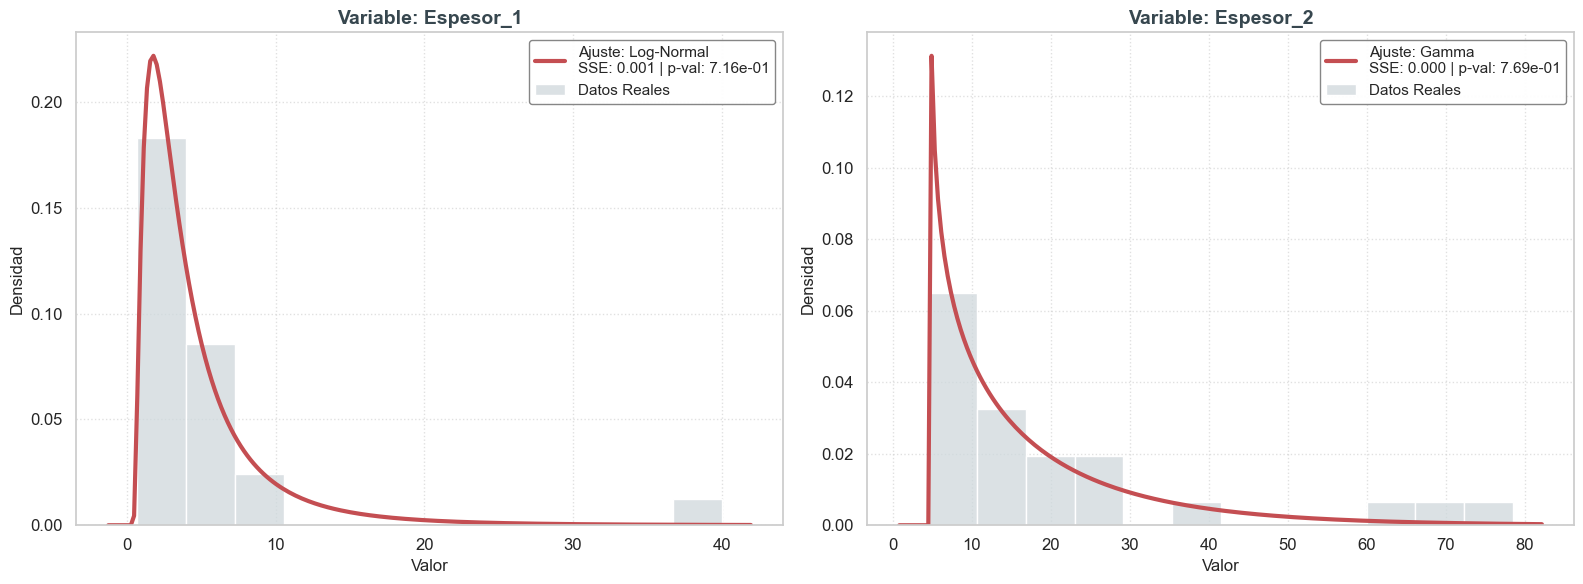

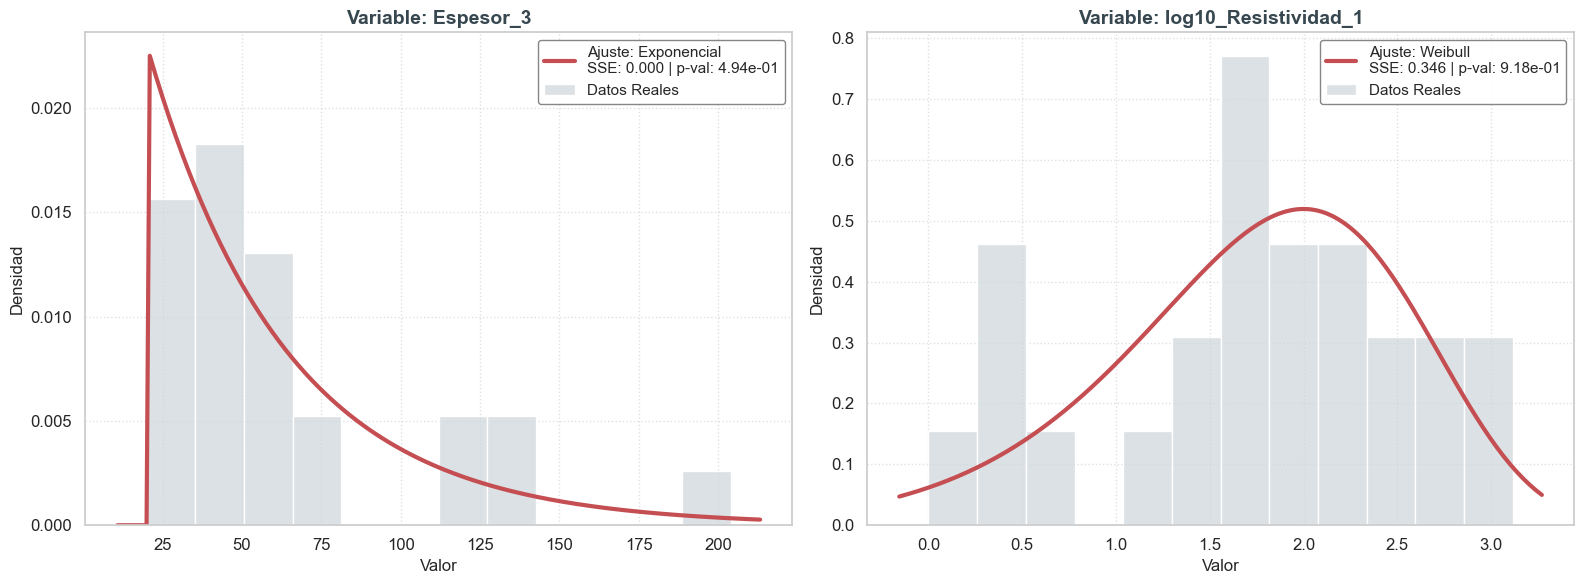

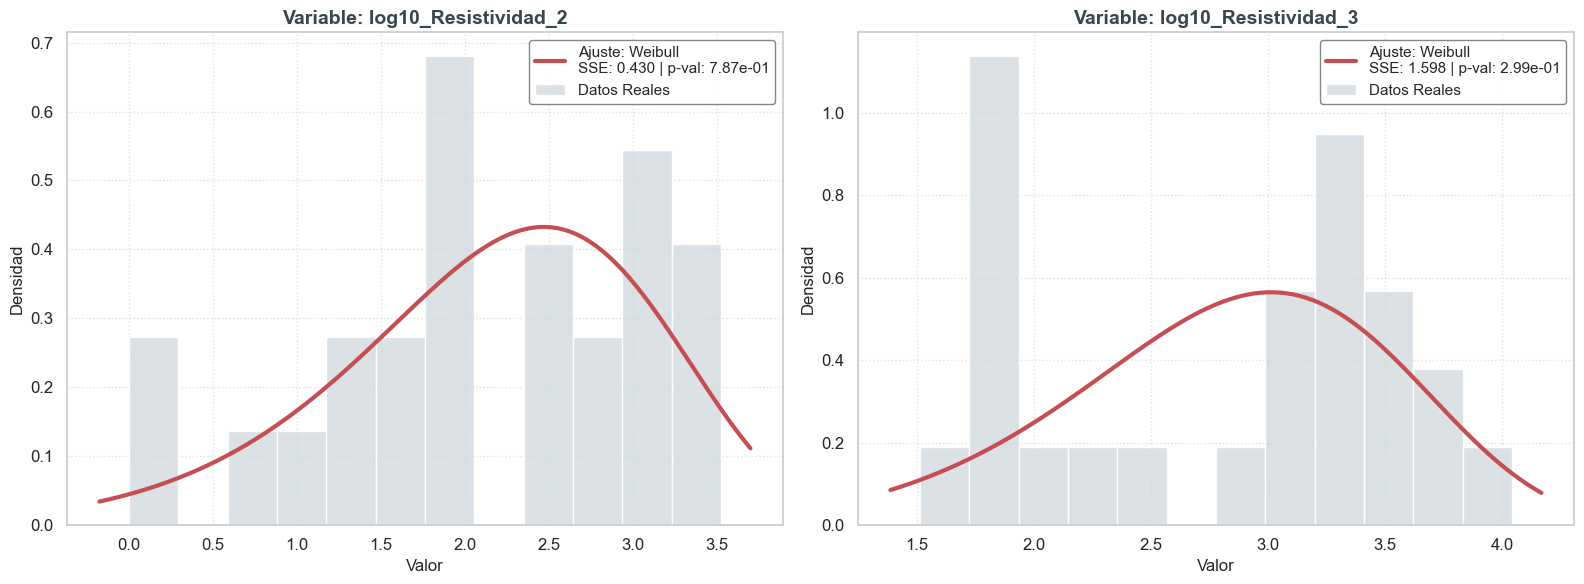

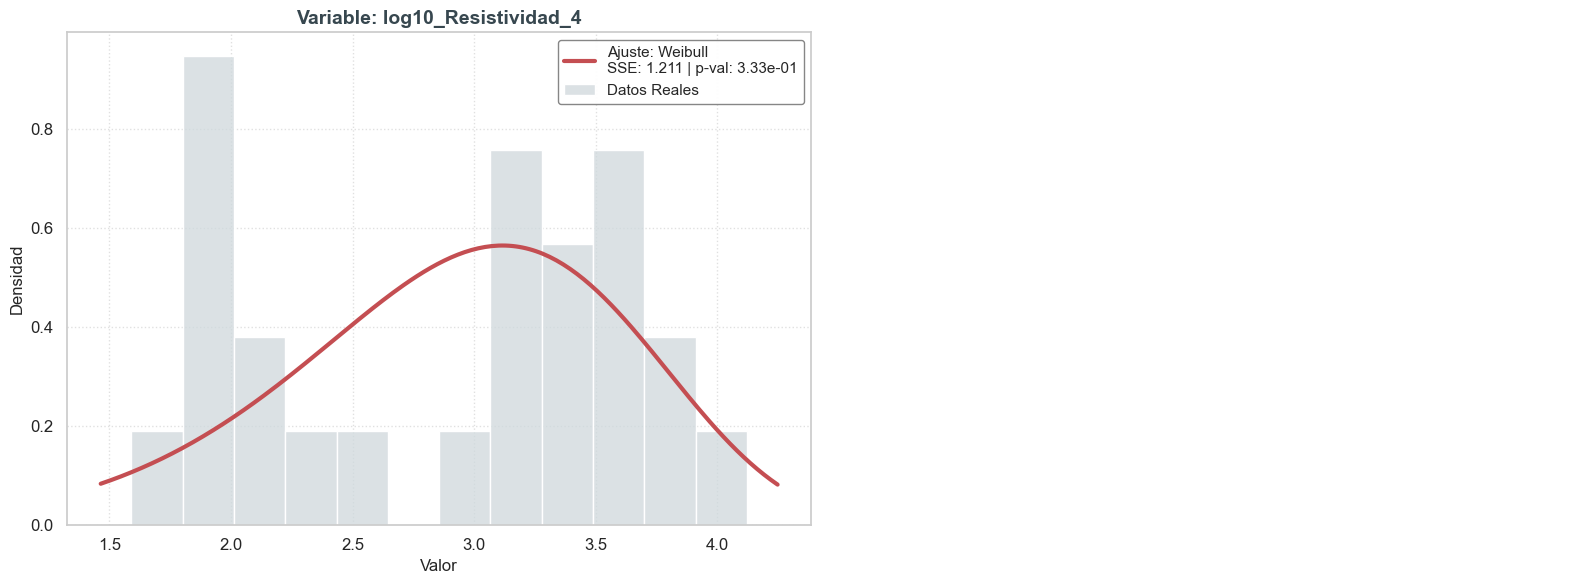

In [37]:
# ==============================================================================
# ANÁLISIS GEOFÍSICO: VISUALIZACIÓN OPTIMIZADA (PARES DE GRÁFICOS)
# ==============================================================================

# 1. IMPORTACIONES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Ignorar advertencias de convergencia matemática
warnings.filterwarnings('ignore')

# Configuración de estilo para diapositivas (fuentes más grandes)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family': 'sans-serif',    # Sans-serif es mejor para presentaciones
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.figsize': (14, 6)       # Formato panorámico para slides
})

# ==============================================================================
# 2. PROCESAMIENTO
# ==============================================================================

def load_data(filepath: str) -> pd.DataFrame:
    try:
        return pd.read_csv(filepath)
    except FileNotFoundError:
        return pd.DataFrame()

def preprocess_resistivity(df: pd.DataFrame, res_cols: list) -> pd.DataFrame:
    """Log-transformación para linealizar resistividades."""
    df_log = df.copy()
    for col in res_cols:
        df_log[f'log10_{col}'] = np.log10(df[col] + 1e-9)
    return df_log

# ==============================================================================
# 3. MOTOR DE AJUSTE ESTADÍSTICO
# ==============================================================================

def get_best_distribution_with_stats(data):
    """
    Selecciona la mejor distribución basándose en el menor error cuadrático (SSE).
    """
    dist_names = ['norm', 'lognorm', 'gamma', 'expon', 'weibull_min']
    
    best_result = {'name': None, 'params': {}, 'sse': np.inf, 'p_value': 0.0}
    
    # Histograma base para cálculo de error
    y_hist, x_hist = np.histogram(data, bins=12, density=True)
    x_mid = (x_hist + np.roll(x_hist, -1))[:-1] / 2.0

    for name in dist_names:
        try:
            dist = getattr(stats, name)
            params = dist.fit(data)
            
            # Error Visual (SSE)
            pdf_vals = dist.pdf(x_mid, *params)
            sse = np.sum(np.power(y_hist - pdf_vals, 2.0))
            
            # Prueba K-S
            D, p = stats.kstest(data, name, args=params)
            
            if sse < best_result['sse']:
                best_result['sse'] = sse
                best_result['name'] = name
                best_result['params'] = params
                best_result['p_value'] = p
        except:
            continue
            
    return best_result

# ==============================================================================
# 4. VISUALIZACIÓN EN PARES (SLIDE-FRIENDLY)
# ==============================================================================

def plot_distribution_pairs(df: pd.DataFrame, thick_cols: list, log_res_cols: list):
    """
    Genera figuras independientes, cada una conteniendo 2 gráficos lado a lado.
    Ideal para copiar y pegar en diapositivas.
    """
    all_vars = thick_cols + log_res_cols
    
    # Diccionario para etiquetas limpias
    nombres_bonitos = {
        'norm': 'Normal', 'lognorm': 'Log-Normal', 
        'gamma': 'Gamma', 'expon': 'Exponencial', 
        'weibull_min': 'Weibull'
    }

    # Iterar de 2 en 2
    for i in range(0, len(all_vars), 2):
        # Crear figura nueva para cada par
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Variables actuales del par
        current_vars = all_vars[i : i+2]
        
        #fig.suptitle(f'Análisis de Distribución: Grupo {i//2 + 1}', fontsize=18, weight='bold', y=1.05)
        
        for j, col in enumerate(current_vars):
            ax = axes[j]
            data = df[col].dropna()
            
            if not data.empty:
                # 1. Ajuste
                res = get_best_distribution_with_stats(data)
                
                # 2. Histograma
                sns.histplot(data, bins=12, stat="density", ax=ax, 
                             color="#CFD8DC", edgecolor="white", label='Datos Reales')
                
                # 3. Curva Teórica
                if res['name']:
                    xmin, xmax = ax.get_xlim()
                    x_plot = np.linspace(xmin, xmax, 200)
                    dist_func = getattr(stats, res['name'])
                    y_plot = dist_func.pdf(x_plot, *res['params'])
                    
                    dist_label = nombres_bonitos.get(res['name'], res['name'])
                    
                    # Leyenda profesional
                    leyenda_txt = (f"Ajuste: {dist_label}\n"
                                   f"SSE: {res['sse']:.3f} | p-val: {res['p_value']:.2e}")
                    
                    ax.plot(x_plot, y_plot, 'r-', linewidth=3, label=leyenda_txt)
                
                ax.set_title(f'Variable: {col}', fontsize=14, weight='bold', color='#37474F')
                ax.set_xlabel('Valor', fontsize=12)
                ax.set_ylabel('Densidad', fontsize=12)
                ax.legend(loc='upper right', frameon=True, framealpha=0.95, edgecolor='gray')
                ax.grid(True, linestyle=':', alpha=0.6)

        # Si el grupo es impar (queda un gráfico solo), apagar el segundo eje
        if len(current_vars) == 1:
            axes[1].axis('off')

        plt.tight_layout()
        plt.show() # Muestra la figura y pasa a la siguiente

# ==============================================================================
# 5. EJECUCIÓN
# ==============================================================================

if __name__ == "__main__":
    # RUTA
    FILE_PATH = "DATOS/Modelos-caracterizados-completo.csv" 
    df = load_data(FILE_PATH)
    
    if not df.empty:
        # Variables
        cols_espesor = ["Espesor_1", "Espesor_2", "Espesor_3"]
        cols_resistividad = ["Resistividad_1", "Resistividad_2", "Resistividad_3", "Resistividad_4"]
        
        # Preprocesamiento
        df_processed = preprocess_resistivity(df, cols_resistividad)
        cols_log_res = [f'log10_{c}' for c in cols_resistividad]

        # Generar Gráficos por Pares
        print("\n>>> Generando gráficos agrupados de 2 en 2 para presentación...")
        plot_distribution_pairs(df_processed, cols_espesor, cols_log_res)
        
    else:
        print("Error: No se cargaron datos.")